In [40]:
import os
def is_running_on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ and os.environ["KAGGLE_KERNEL_RUN_TYPE"] == "Interactive"
DATA_PATH = '/kaggle/input/aerial-cactus/' if is_running_on_kaggle() else 'data/'
print('Running on Kaggle' if is_running_on_kaggle() else 'Running locally')

Running locally


In [41]:
import torch
import torchvision
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import pandas as pd

In [42]:
# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [43]:
ANNOTATIONS_FILE = DATA_PATH + 'train.csv'
IMG_DIR = DATA_PATH + 'train/train/'
CHECKPOINT_DIR = '/kaggle/working/checkpoints' if is_running_on_kaggle() else 'checkpoints/'
FIGURES_DIR = '/kaggle/working/figures' if is_running_on_kaggle() else 'figures/'

SEED = 42
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
TRAIN_SPLIT = 0.8
EPOCHS = 100 if is_running_on_kaggle() else 100

In [44]:
torch.manual_seed(42)

In [45]:
from torchvision.io import read_image

class CactusDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [46]:
import torchvision.transforms as transforms

# mean and std of the cactai dataset
mean = [0.5035902857780457, 0.451941579580307, 0.4681771695613861]
std = [0.15118408203125, 0.1397838294506073, 0.15320344269275665]

transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=mean, std=std),
])

In [47]:
# Create the dataset object
trainval_data = CactusDataset(ANNOTATIONS_FILE, IMG_DIR, transform=transform)

# Print the shape of the first image in the dataset
print(trainval_data[0][0].shape)

torch.Size([3, 32, 32])


In [48]:
from torch.utils.data import random_split

# Define the sizes of training and validation sets
train_size = int(TRAIN_SPLIT * len(trainval_data))
val_size = len(trainval_data) - train_size

# Split the dataset into training and validation sets
train_data, val_data = random_split(trainval_data, [train_size, val_size])

# Print the sizes of the training and validation sets
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))

Training set size: 14000
Validation set size: 3500


In [49]:
# Utility function for saving epochs checkpoints
def save_checkpoint(model, optimizer, loss, dir, desc):
    checkpoint_dir = os.path.join(CHECKPOINT_DIR, dir)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{desc}.pt')
    torch.save({
        'desc': desc,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)

# Utility function for loading epochs checkpoints
def load_checkpoint(model, optimizer, dir, desc):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, dir, f'checkpoint_{desc}.pt')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    return model, optimizer, loss

In [50]:
# Training loop (1 epoch)
def train_model(train_dataloader, model, criterion, optimizer, checkpoint=False, desc='Training', dir_checkpoint=None):
    avg_train_loss = 0
    train_bar = tqdm(train_dataloader, desc=desc, leave=False)
    
    model.train()
    for X, y in train_bar:
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X.float())
        y = y.reshape(-1, 1).float()
        loss = criterion(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the average loss
        avg_train_loss += loss.item() * len(y)

        # Update the loading bar
        train_bar.set_postfix({'loss': loss.item()})
        
    avg_train_loss = avg_train_loss / len(train_dataloader.dataset)
    train_bar.set_postfix({'loss': avg_train_loss})
    train_bar.close()
    return avg_train_loss

In [51]:
# Compute validation loss and error rate
def evaluate(val_dataloader, model, criterion, desc='Validation'):
    avg_val_loss = 0
    errors = []
    val_bar = tqdm(val_dataloader, desc=desc, leave=False)

    model.eval()
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    with torch.no_grad():
        for X, y in val_bar:
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model(X.float())
            y = y.reshape(-1, 1).float()
            loss = criterion(pred, y)

            # Save errors for error rate
            pred = nn.Sigmoid()(pred) > 0.5

            tp += torch.bitwise_and(y == 1, pred == 1).sum().item()
            tn += torch.bitwise_and(y == 0, pred == 0).sum().item()
            fp += torch.bitwise_and(y == 0, pred == 1).sum().item()
            fn += torch.bitwise_and(y == 1, pred == 0).sum().item()

            errors += pred != y

            # Update the average loss
            avg_val_loss += loss.item() * len(y)

            # Update the loading bar
            val_bar.set_postfix({'loss': loss.item()})
    
    avg_val_loss = avg_val_loss / len(val_dataloader.dataset)
    val_bar.set_postfix({'loss': avg_val_loss})
    val_bar.close()
    return avg_val_loss, errors, [[tp, fp], [fn, tn]]

In [52]:
# Early stopping
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [53]:
class CustomConvNet(torch.nn.Module):
    def __init__(self, fc_size, dropout):
        super(CustomConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, fc_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(fc_size, 1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [54]:
def f1_score(confusion_matrix):
    tp, fp = confusion_matrix[0]
    fn, _ = confusion_matrix[1]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return 2 * (precision * recall) / (precision + recall)

>>>>>>>>     FC Size: 6 - Dropout: 0.1     <<<<<<<<


TrainingEpoch01:   0%|          | 0/219 [00:00<?, ?it/s, loss=0.769]

Epoch 1/100	 Train Loss: 0.2417 - Val Loss: 0.0881 - Error Rate: 0.0280 - F1 Score: 0.9815 - (FPR: 0.0133 - FNR: 0.0733)


Epoch 2/100	 Train Loss: 0.0976 - Val Loss: 0.0611 - Error Rate: 0.0211 - F1 Score: 0.9861 - (FPR: 0.0120 - FNR: 0.0499)


Epoch 3/100	 Train Loss: 0.0797 - Val Loss: 0.0595 - Error Rate: 0.0197 - F1 Score: 0.9872 - (FPR: 0.0207 - FNR: 0.0165)


Epoch 4/100	 Train Loss: 0.0593 - Val Loss: 0.0373 - Error Rate: 0.0109 - F1 Score: 0.9929 - (FPR: 0.0093 - FNR: 0.0159)


Epoch 5/100	 Train Loss: 0.0479 - Val Loss: 0.0302 - Error Rate: 0.0083 - F1 Score: 0.9946 - (FPR: 0.0067 - FNR: 0.0133)


Epoch 6/100	 Train Loss: 0.0437 - Val Loss: 0.0363 - Error Rate: 0.0123 - F1 Score: 0.9919 - (FPR: 0.0045 - FNR: 0.0364)


Epoch 7/100	 Train Loss: 0.0363 - Val Loss: 0.0321 - Error Rate: 0.0106 - F1 Score: 0.9931 - (FPR: 0.0104 - FNR: 0.0111)


Epoch 8/100	 Train Loss: 0.0318 - Val Loss: 0.0314 - Error Rate: 0.0100 - F1 Score: 0.9935 - (FPR: 0.0111 - FNR: 0.0062)


Epoch 9/100	 Train Loss: 0.0260 - Val Loss: 0.0339 - Error Rate: 0.0111 - F1 Score: 0.9927 - (FPR: 0.0038 - FNR: 0.0341)


Epoch 10/100	 Train Loss: 0.0225 - Val Loss: 0.0498 - Error Rate: 0.0140 - F1 Score: 0.9909 - (FPR: 0.0152 - FNR: 0.0100)


Epoch 11/100	 Train Loss: 0.0196 - Val Loss: 0.0636 - Error Rate: 0.0197 - F1 Score: 0.9872 - (FPR: 0.0214 - FNR: 0.0140)


Epoch 12/100	 Train Loss: 0.0224 - Val Loss: 0.0279 - Error Rate: 0.0077 - F1 Score: 0.9949 - (FPR: 0.0045 - FNR: 0.0180)


Epoch 13/100	 Train Loss: 0.0177 - Val Loss: 0.0284 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0082 - FNR: 0.0134)


Epoch 14/100	 Train Loss: 0.0120 - Val Loss: 0.0371 - Error Rate: 0.0129 - F1 Score: 0.9916 - (FPR: 0.0137 - FNR: 0.0100)


Epoch 15/100	 Train Loss: 0.0097 - Val Loss: 0.0345 - Error Rate: 0.0091 - F1 Score: 0.9940 - (FPR: 0.0071 - FNR: 0.0157)


Epoch 16/100	 Train Loss: 0.0092 - Val Loss: 0.0443 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0086 - FNR: 0.0122)


Epoch 17/100	 Train Loss: 0.0214 - Val Loss: 0.0460 - Error Rate: 0.0106 - F1 Score: 0.9930 - (FPR: 0.0026 - FNR: 0.0351)


Epoch 18/100	 Train Loss: 0.0095 - Val Loss: 0.0417 - Error Rate: 0.0091 - F1 Score: 0.9940 - (FPR: 0.0034 - FNR: 0.0272)


Epoch 19/100	 Train Loss: 0.0056 - Val Loss: 0.0392 - Error Rate: 0.0091 - F1 Score: 0.9940 - (FPR: 0.0023 - FNR: 0.0305)


Epoch 20/100	 Train Loss: 0.0055 - Val Loss: 0.0383 - Error Rate: 0.0083 - F1 Score: 0.9946 - (FPR: 0.0075 - FNR: 0.0110)


Epoch 21/100	 Train Loss: 0.0038 - Val Loss: 0.0411 - Error Rate: 0.0080 - F1 Score: 0.9948 - (FPR: 0.0052 - FNR: 0.0168)


Epoch 22/100	 Train Loss: 0.0098 - Val Loss: 0.0480 - Error Rate: 0.0106 - F1 Score: 0.9931 - (FPR: 0.0071 - FNR: 0.0217)


Epoch 23/100	 Train Loss: 0.0138 - Val Loss: 0.0478 - Error Rate: 0.0109 - F1 Score: 0.9929 - (FPR: 0.0053 - FNR: 0.0285)
Early stopping on epoch 23


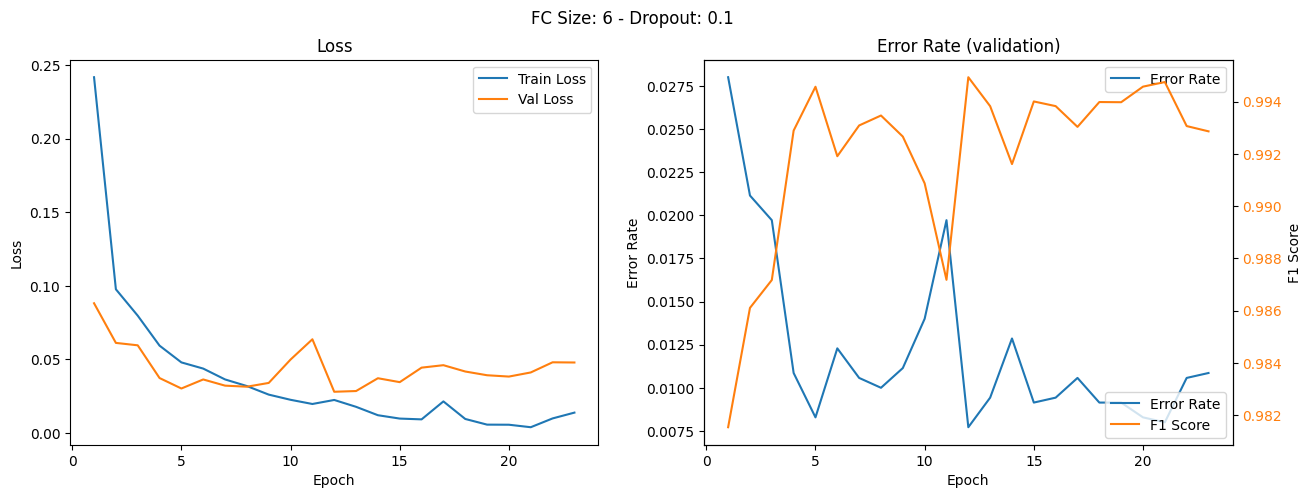

>>>>>>>>     FC Size: 6 - Dropout: 0.3     <<<<<<<<


Epoch 1/100	 Train Loss: 0.3575 - Val Loss: 0.1188 - Error Rate: 0.0357 - F1 Score: 0.9767 - (FPR: 0.0303 - FNR: 0.0542)


Epoch 2/100	 Train Loss: 0.2591 - Val Loss: 0.1000 - Error Rate: 0.0251 - F1 Score: 0.9834 - (FPR: 0.0106 - FNR: 0.0694)


Epoch 3/100	 Train Loss: 0.2279 - Val Loss: 0.0574 - Error Rate: 0.0200 - F1 Score: 0.9868 - (FPR: 0.0091 - FNR: 0.0539)


Epoch 4/100	 Train Loss: 0.1796 - Val Loss: 0.0443 - Error Rate: 0.0120 - F1 Score: 0.9921 - (FPR: 0.0079 - FNR: 0.0252)


Epoch 5/100	 Train Loss: 0.1600 - Val Loss: 0.0545 - Error Rate: 0.0154 - F1 Score: 0.9898 - (FPR: 0.0049 - FNR: 0.0477)


Epoch 6/100	 Train Loss: 0.1428 - Val Loss: 0.0341 - Error Rate: 0.0117 - F1 Score: 0.9923 - (FPR: 0.0097 - FNR: 0.0183)


Epoch 7/100	 Train Loss: 0.1330 - Val Loss: 0.0310 - Error Rate: 0.0114 - F1 Score: 0.9925 - (FPR: 0.0108 - FNR: 0.0135)


Epoch 8/100	 Train Loss: 0.1162 - Val Loss: 0.0331 - Error Rate: 0.0106 - F1 Score: 0.9931 - (FPR: 0.0101 - FNR: 0.0123)


Epoch 9/100	 Train Loss: 0.1112 - Val Loss: 0.0687 - Error Rate: 0.0171 - F1 Score: 0.9887 - (FPR: 0.0076 - FNR: 0.0469)


Epoch 10/100	 Train Loss: 0.1110 - Val Loss: 0.0262 - Error Rate: 0.0086 - F1 Score: 0.9944 - (FPR: 0.0041 - FNR: 0.0226)


Epoch 11/100	 Train Loss: 0.1001 - Val Loss: 0.0194 - Error Rate: 0.0063 - F1 Score: 0.9959 - (FPR: 0.0052 - FNR: 0.0097)


Epoch 12/100	 Train Loss: 0.1004 - Val Loss: 0.0347 - Error Rate: 0.0103 - F1 Score: 0.9932 - (FPR: 0.0034 - FNR: 0.0318)


Epoch 13/100	 Train Loss: 0.0827 - Val Loss: 0.0245 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0023 - FNR: 0.0259)


Epoch 14/100	 Train Loss: 0.0882 - Val Loss: 0.0418 - Error Rate: 0.0106 - F1 Score: 0.9930 - (FPR: 0.0015 - FNR: 0.0383)


Epoch 15/100	 Train Loss: 0.0903 - Val Loss: 0.0221 - Error Rate: 0.0063 - F1 Score: 0.9959 - (FPR: 0.0038 - FNR: 0.0144)


Epoch 16/100	 Train Loss: 0.0930 - Val Loss: 0.0338 - Error Rate: 0.0126 - F1 Score: 0.9918 - (FPR: 0.0101 - FNR: 0.0207)


Epoch 17/100	 Train Loss: 0.0870 - Val Loss: 0.0234 - Error Rate: 0.0074 - F1 Score: 0.9951 - (FPR: 0.0034 - FNR: 0.0202)


Epoch 18/100	 Train Loss: 0.0861 - Val Loss: 0.0302 - Error Rate: 0.0074 - F1 Score: 0.9951 - (FPR: 0.0023 - FNR: 0.0236)


Epoch 19/100	 Train Loss: 0.0829 - Val Loss: 0.0381 - Error Rate: 0.0123 - F1 Score: 0.9920 - (FPR: 0.0130 - FNR: 0.0099)


Epoch 20/100	 Train Loss: 0.0886 - Val Loss: 0.0393 - Error Rate: 0.0097 - F1 Score: 0.9936 - (FPR: 0.0019 - FNR: 0.0339)


Epoch 21/100	 Train Loss: 0.0845 - Val Loss: 0.0284 - Error Rate: 0.0077 - F1 Score: 0.9949 - (FPR: 0.0008 - FNR: 0.0292)
Early stopping on epoch 21


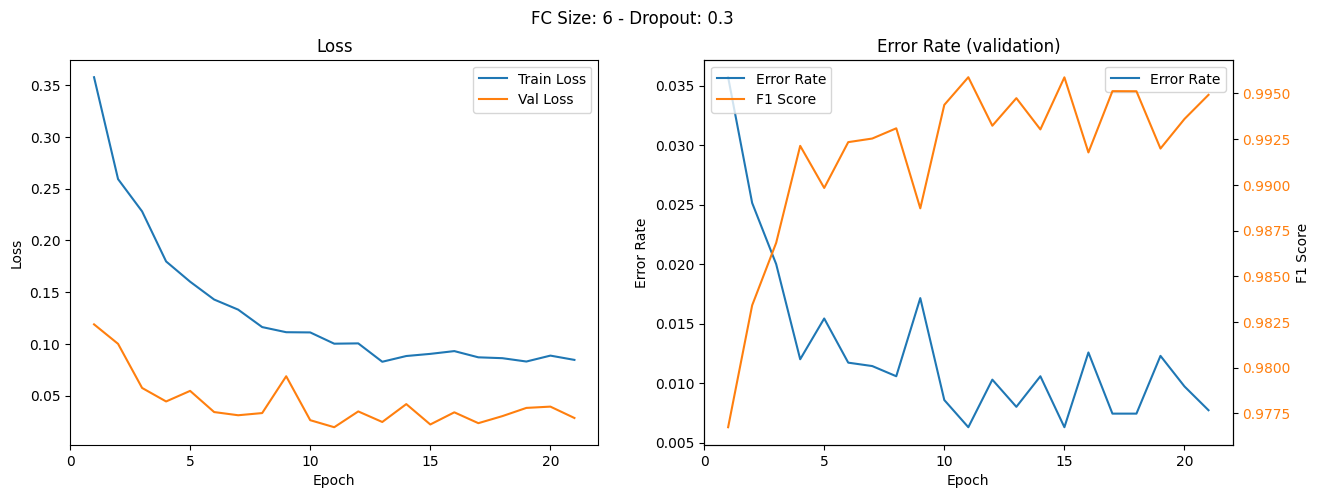

>>>>>>>>     FC Size: 6 - Dropout: 0.5     <<<<<<<<


Epoch 1/100	 Train Loss: 0.3420 - Val Loss: 0.1273 - Error Rate: 0.0429 - F1 Score: 0.9724 - (FPR: 0.0435 - FNR: 0.0404)


Epoch 2/100	 Train Loss: 0.2288 - Val Loss: 0.0833 - Error Rate: 0.0266 - F1 Score: 0.9827 - (FPR: 0.0261 - FNR: 0.0281)


Epoch 3/100	 Train Loss: 0.2097 - Val Loss: 0.0828 - Error Rate: 0.0294 - F1 Score: 0.9810 - (FPR: 0.0331 - FNR: 0.0159)


Epoch 4/100	 Train Loss: 0.1928 - Val Loss: 0.0750 - Error Rate: 0.0223 - F1 Score: 0.9855 - (FPR: 0.0249 - FNR: 0.0129)


Epoch 5/100	 Train Loss: 0.1881 - Val Loss: 0.0552 - Error Rate: 0.0160 - F1 Score: 0.9895 - (FPR: 0.0101 - FNR: 0.0348)


Epoch 6/100	 Train Loss: 0.1899 - Val Loss: 0.0701 - Error Rate: 0.0171 - F1 Score: 0.9888 - (FPR: 0.0145 - FNR: 0.0258)


Epoch 7/100	 Train Loss: 0.1791 - Val Loss: 0.0409 - Error Rate: 0.0106 - F1 Score: 0.9931 - (FPR: 0.0064 - FNR: 0.0240)


Epoch 8/100	 Train Loss: 0.1718 - Val Loss: 0.0428 - Error Rate: 0.0131 - F1 Score: 0.9913 - (FPR: 0.0042 - FNR: 0.0409)


Epoch 9/100	 Train Loss: 0.1669 - Val Loss: 0.0399 - Error Rate: 0.0109 - F1 Score: 0.9929 - (FPR: 0.0097 - FNR: 0.0147)


Epoch 10/100	 Train Loss: 0.1690 - Val Loss: 0.0376 - Error Rate: 0.0117 - F1 Score: 0.9923 - (FPR: 0.0023 - FNR: 0.0407)


Epoch 11/100	 Train Loss: 0.1662 - Val Loss: 0.0406 - Error Rate: 0.0157 - F1 Score: 0.9897 - (FPR: 0.0064 - FNR: 0.0445)


Epoch 12/100	 Train Loss: 0.1633 - Val Loss: 0.0434 - Error Rate: 0.0111 - F1 Score: 0.9927 - (FPR: 0.0119 - FNR: 0.0087)


Epoch 13/100	 Train Loss: 0.1552 - Val Loss: 0.0354 - Error Rate: 0.0100 - F1 Score: 0.9935 - (FPR: 0.0086 - FNR: 0.0146)


Epoch 14/100	 Train Loss: 0.1625 - Val Loss: 0.0306 - Error Rate: 0.0077 - F1 Score: 0.9949 - (FPR: 0.0034 - FNR: 0.0214)


Epoch 15/100	 Train Loss: 0.1572 - Val Loss: 0.0343 - Error Rate: 0.0091 - F1 Score: 0.9940 - (FPR: 0.0093 - FNR: 0.0086)


Epoch 16/100	 Train Loss: 0.1573 - Val Loss: 0.0270 - Error Rate: 0.0091 - F1 Score: 0.9940 - (FPR: 0.0026 - FNR: 0.0294)


Epoch 17/100	 Train Loss: 0.1578 - Val Loss: 0.0263 - Error Rate: 0.0086 - F1 Score: 0.9944 - (FPR: 0.0049 - FNR: 0.0203)


Epoch 18/100	 Train Loss: 0.1584 - Val Loss: 0.0333 - Error Rate: 0.0083 - F1 Score: 0.9946 - (FPR: 0.0049 - FNR: 0.0192)


Epoch 19/100	 Train Loss: 0.1508 - Val Loss: 0.0297 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0045 - FNR: 0.0191)


Epoch 20/100	 Train Loss: 0.1571 - Val Loss: 0.0427 - Error Rate: 0.0140 - F1 Score: 0.9908 - (FPR: 0.0057 - FNR: 0.0400)


Epoch 21/100	 Train Loss: 0.1567 - Val Loss: 0.0866 - Error Rate: 0.0163 - F1 Score: 0.9894 - (FPR: 0.0181 - FNR: 0.0101)


Epoch 22/100	 Train Loss: 0.1521 - Val Loss: 0.0290 - Error Rate: 0.0080 - F1 Score: 0.9948 - (FPR: 0.0049 - FNR: 0.0180)


Epoch 23/100	 Train Loss: 0.1515 - Val Loss: 0.0359 - Error Rate: 0.0083 - F1 Score: 0.9946 - (FPR: 0.0071 - FNR: 0.0122)


Epoch 24/100	 Train Loss: 0.1649 - Val Loss: 0.0312 - Error Rate: 0.0063 - F1 Score: 0.9959 - (FPR: 0.0060 - FNR: 0.0073)


Epoch 25/100	 Train Loss: 0.1563 - Val Loss: 0.0285 - Error Rate: 0.0080 - F1 Score: 0.9948 - (FPR: 0.0056 - FNR: 0.0157)


Epoch 26/100	 Train Loss: 0.1545 - Val Loss: 0.0368 - Error Rate: 0.0080 - F1 Score: 0.9948 - (FPR: 0.0078 - FNR: 0.0086)


Epoch 27/100	 Train Loss: 0.1503 - Val Loss: 0.0366 - Error Rate: 0.0074 - F1 Score: 0.9951 - (FPR: 0.0078 - FNR: 0.0061)
Early stopping on epoch 27


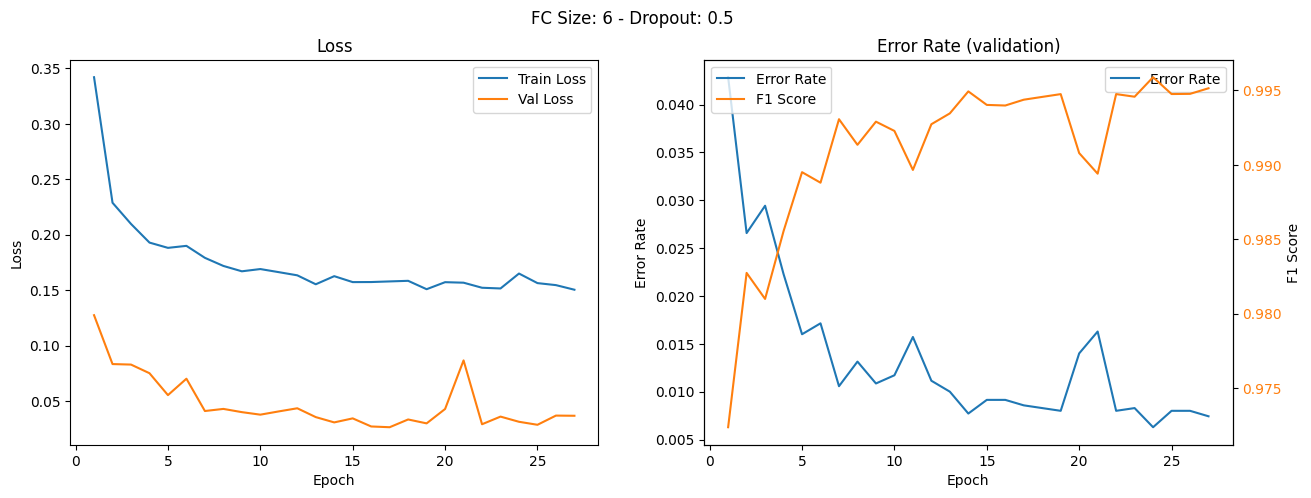

>>>>>>>>     FC Size: 12 - Dropout: 0.1     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2013 - Val Loss: 0.0751 - Error Rate: 0.0240 - F1 Score: 0.9842 - (FPR: 0.0143 - FNR: 0.0548)


Epoch 2/100	 Train Loss: 0.0951 - Val Loss: 0.0689 - Error Rate: 0.0246 - F1 Score: 0.9840 - (FPR: 0.0243 - FNR: 0.0254)


Epoch 3/100	 Train Loss: 0.0757 - Val Loss: 0.0608 - Error Rate: 0.0197 - F1 Score: 0.9871 - (FPR: 0.0189 - FNR: 0.0225)


Epoch 4/100	 Train Loss: 0.0611 - Val Loss: 0.0454 - Error Rate: 0.0163 - F1 Score: 0.9893 - (FPR: 0.0109 - FNR: 0.0337)


Epoch 5/100	 Train Loss: 0.0472 - Val Loss: 0.0374 - Error Rate: 0.0134 - F1 Score: 0.9912 - (FPR: 0.0064 - FNR: 0.0355)


Epoch 6/100	 Train Loss: 0.0376 - Val Loss: 0.0431 - Error Rate: 0.0154 - F1 Score: 0.9899 - (FPR: 0.0130 - FNR: 0.0233)


Epoch 7/100	 Train Loss: 0.0275 - Val Loss: 0.0267 - Error Rate: 0.0103 - F1 Score: 0.9933 - (FPR: 0.0064 - FNR: 0.0228)


Epoch 8/100	 Train Loss: 0.0284 - Val Loss: 0.0317 - Error Rate: 0.0100 - F1 Score: 0.9934 - (FPR: 0.0034 - FNR: 0.0306)


Epoch 9/100	 Train Loss: 0.0202 - Val Loss: 0.0283 - Error Rate: 0.0100 - F1 Score: 0.9935 - (FPR: 0.0090 - FNR: 0.0134)


Epoch 10/100	 Train Loss: 0.0099 - Val Loss: 0.0378 - Error Rate: 0.0131 - F1 Score: 0.9913 - (FPR: 0.0011 - FNR: 0.0493)


Epoch 11/100	 Train Loss: 0.0134 - Val Loss: 0.0415 - Error Rate: 0.0109 - F1 Score: 0.9928 - (FPR: 0.0019 - FNR: 0.0384)


Epoch 12/100	 Train Loss: 0.0088 - Val Loss: 0.0294 - Error Rate: 0.0100 - F1 Score: 0.9934 - (FPR: 0.0041 - FNR: 0.0284)


Epoch 13/100	 Train Loss: 0.0059 - Val Loss: 0.0323 - Error Rate: 0.0086 - F1 Score: 0.9944 - (FPR: 0.0049 - FNR: 0.0203)


Epoch 14/100	 Train Loss: 0.0097 - Val Loss: 0.0306 - Error Rate: 0.0080 - F1 Score: 0.9948 - (FPR: 0.0078 - FNR: 0.0086)


Epoch 15/100	 Train Loss: 0.0051 - Val Loss: 0.0303 - Error Rate: 0.0074 - F1 Score: 0.9951 - (FPR: 0.0052 - FNR: 0.0145)


Epoch 16/100	 Train Loss: 0.0023 - Val Loss: 0.0300 - Error Rate: 0.0074 - F1 Score: 0.9951 - (FPR: 0.0038 - FNR: 0.0191)


Epoch 17/100	 Train Loss: 0.0053 - Val Loss: 0.0366 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0082 - FNR: 0.0134)
Early stopping on epoch 17


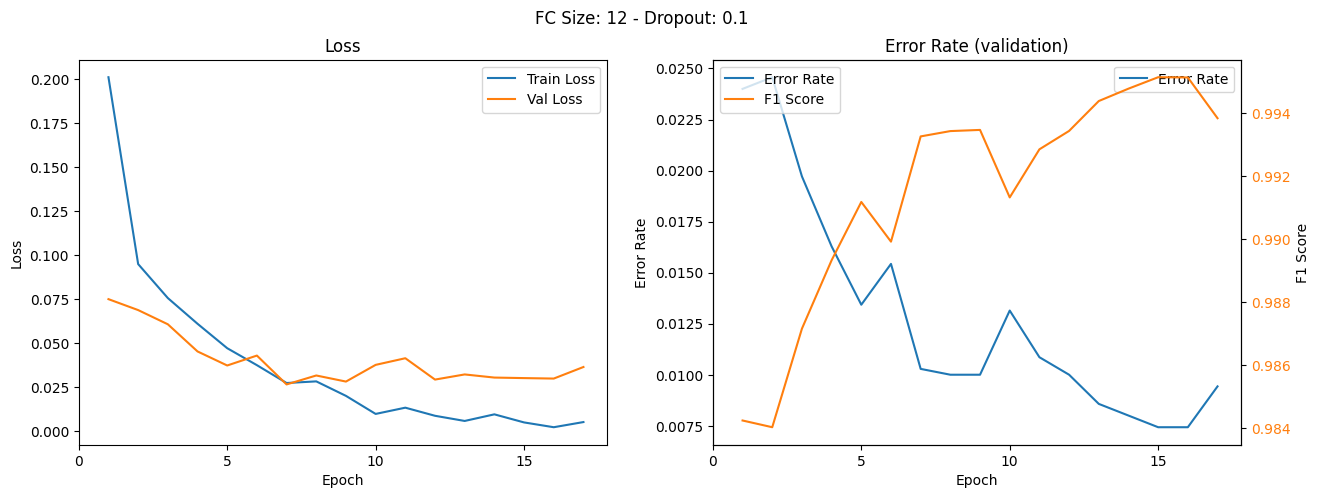

>>>>>>>>     FC Size: 12 - Dropout: 0.3     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2478 - Val Loss: 0.0976 - Error Rate: 0.0254 - F1 Score: 0.9833 - (FPR: 0.0136 - FNR: 0.0624)


Epoch 2/100	 Train Loss: 0.1263 - Val Loss: 0.0655 - Error Rate: 0.0211 - F1 Score: 0.9860 - (FPR: 0.0068 - FNR: 0.0644)


Epoch 3/100	 Train Loss: 0.1033 - Val Loss: 0.0585 - Error Rate: 0.0206 - F1 Score: 0.9864 - (FPR: 0.0072 - FNR: 0.0612)


Epoch 4/100	 Train Loss: 0.0857 - Val Loss: 0.0523 - Error Rate: 0.0157 - F1 Score: 0.9897 - (FPR: 0.0123 - FNR: 0.0268)


Epoch 5/100	 Train Loss: 0.0776 - Val Loss: 0.0420 - Error Rate: 0.0137 - F1 Score: 0.9910 - (FPR: 0.0064 - FNR: 0.0366)


Epoch 6/100	 Train Loss: 0.0670 - Val Loss: 0.0424 - Error Rate: 0.0109 - F1 Score: 0.9929 - (FPR: 0.0093 - FNR: 0.0159)


Epoch 7/100	 Train Loss: 0.0598 - Val Loss: 0.0485 - Error Rate: 0.0126 - F1 Score: 0.9918 - (FPR: 0.0137 - FNR: 0.0087)


Epoch 8/100	 Train Loss: 0.0531 - Val Loss: 0.0342 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0038 - FNR: 0.0272)


Epoch 9/100	 Train Loss: 0.0418 - Val Loss: 0.0361 - Error Rate: 0.0089 - F1 Score: 0.9942 - (FPR: 0.0078 - FNR: 0.0122)


Epoch 10/100	 Train Loss: 0.0400 - Val Loss: 0.0299 - Error Rate: 0.0080 - F1 Score: 0.9948 - (FPR: 0.0049 - FNR: 0.0180)


Epoch 11/100	 Train Loss: 0.0378 - Val Loss: 0.0406 - Error Rate: 0.0100 - F1 Score: 0.9935 - (FPR: 0.0100 - FNR: 0.0098)


Epoch 12/100	 Train Loss: 0.0295 - Val Loss: 0.1308 - Error Rate: 0.0254 - F1 Score: 0.9836 - (FPR: 0.0309 - FNR: 0.0053)


Epoch 13/100	 Train Loss: 0.0340 - Val Loss: 0.0510 - Error Rate: 0.0114 - F1 Score: 0.9925 - (FPR: 0.0060 - FNR: 0.0286)


Epoch 14/100	 Train Loss: 0.0216 - Val Loss: 0.0322 - Error Rate: 0.0083 - F1 Score: 0.9946 - (FPR: 0.0064 - FNR: 0.0145)


Epoch 15/100	 Train Loss: 0.0142 - Val Loss: 0.0405 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0041 - FNR: 0.0203)


Epoch 16/100	 Train Loss: 0.0341 - Val Loss: 0.0422 - Error Rate: 0.0100 - F1 Score: 0.9935 - (FPR: 0.0097 - FNR: 0.0110)


Epoch 17/100	 Train Loss: 0.0146 - Val Loss: 0.0326 - Error Rate: 0.0069 - F1 Score: 0.9955 - (FPR: 0.0041 - FNR: 0.0156)


Epoch 18/100	 Train Loss: 0.0148 - Val Loss: 0.0312 - Error Rate: 0.0063 - F1 Score: 0.9959 - (FPR: 0.0067 - FNR: 0.0049)


Epoch 19/100	 Train Loss: 0.0097 - Val Loss: 0.0310 - Error Rate: 0.0051 - F1 Score: 0.9966 - (FPR: 0.0034 - FNR: 0.0108)


Epoch 20/100	 Train Loss: 0.0157 - Val Loss: 0.0343 - Error Rate: 0.0066 - F1 Score: 0.9957 - (FPR: 0.0067 - FNR: 0.0061)
Early stopping on epoch 20


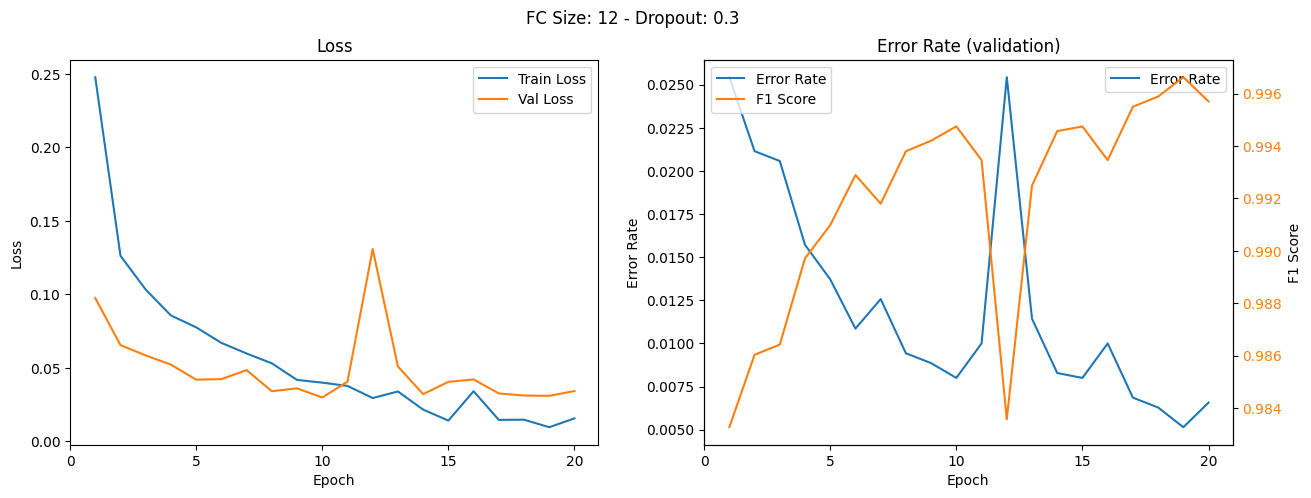

>>>>>>>>     FC Size: 12 - Dropout: 0.5     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2320 - Val Loss: 0.0797 - Error Rate: 0.0254 - F1 Score: 0.9834 - (FPR: 0.0197 - FNR: 0.0442)


Epoch 2/100	 Train Loss: 0.1257 - Val Loss: 0.0571 - Error Rate: 0.0174 - F1 Score: 0.9886 - (FPR: 0.0101 - FNR: 0.0405)


Epoch 3/100	 Train Loss: 0.0963 - Val Loss: 0.0708 - Error Rate: 0.0243 - F1 Score: 0.9843 - (FPR: 0.0271 - FNR: 0.0143)


Epoch 4/100	 Train Loss: 0.0836 - Val Loss: 0.0561 - Error Rate: 0.0186 - F1 Score: 0.9879 - (FPR: 0.0189 - FNR: 0.0176)


Epoch 5/100	 Train Loss: 0.0653 - Val Loss: 0.0407 - Error Rate: 0.0160 - F1 Score: 0.9896 - (FPR: 0.0181 - FNR: 0.0089)


Epoch 6/100	 Train Loss: 0.0613 - Val Loss: 0.0437 - Error Rate: 0.0126 - F1 Score: 0.9918 - (FPR: 0.0137 - FNR: 0.0087)


Epoch 7/100	 Train Loss: 0.0521 - Val Loss: 0.0318 - Error Rate: 0.0103 - F1 Score: 0.9933 - (FPR: 0.0093 - FNR: 0.0134)


Epoch 8/100	 Train Loss: 0.0473 - Val Loss: 0.0298 - Error Rate: 0.0109 - F1 Score: 0.9929 - (FPR: 0.0079 - FNR: 0.0205)


Epoch 9/100	 Train Loss: 0.0376 - Val Loss: 0.0318 - Error Rate: 0.0109 - F1 Score: 0.9929 - (FPR: 0.0079 - FNR: 0.0205)


Epoch 10/100	 Train Loss: 0.0344 - Val Loss: 0.0382 - Error Rate: 0.0126 - F1 Score: 0.9917 - (FPR: 0.0034 - FNR: 0.0408)


Epoch 11/100	 Train Loss: 0.0322 - Val Loss: 0.0279 - Error Rate: 0.0091 - F1 Score: 0.9940 - (FPR: 0.0093 - FNR: 0.0086)


Epoch 12/100	 Train Loss: 0.0296 - Val Loss: 0.0276 - Error Rate: 0.0074 - F1 Score: 0.9951 - (FPR: 0.0049 - FNR: 0.0156)


Epoch 13/100	 Train Loss: 0.0226 - Val Loss: 0.0473 - Error Rate: 0.0123 - F1 Score: 0.9919 - (FPR: 0.0075 - FNR: 0.0275)


Epoch 14/100	 Train Loss: 0.0255 - Val Loss: 0.0283 - Error Rate: 0.0097 - F1 Score: 0.9936 - (FPR: 0.0089 - FNR: 0.0122)


Epoch 15/100	 Train Loss: 0.0269 - Val Loss: 0.0377 - Error Rate: 0.0086 - F1 Score: 0.9944 - (FPR: 0.0093 - FNR: 0.0062)


Epoch 16/100	 Train Loss: 0.0276 - Val Loss: 0.0353 - Error Rate: 0.0106 - F1 Score: 0.9931 - (FPR: 0.0108 - FNR: 0.0099)


Epoch 17/100	 Train Loss: 0.0246 - Val Loss: 0.0252 - Error Rate: 0.0077 - F1 Score: 0.9949 - (FPR: 0.0041 - FNR: 0.0191)


Epoch 18/100	 Train Loss: 0.0205 - Val Loss: 0.0593 - Error Rate: 0.0106 - F1 Score: 0.9930 - (FPR: 0.0026 - FNR: 0.0351)


Epoch 19/100	 Train Loss: 0.0192 - Val Loss: 0.0643 - Error Rate: 0.0120 - F1 Score: 0.9922 - (FPR: 0.0141 - FNR: 0.0050)


Epoch 20/100	 Train Loss: 0.0220 - Val Loss: 0.0434 - Error Rate: 0.0097 - F1 Score: 0.9936 - (FPR: 0.0056 - FNR: 0.0227)


Epoch 21/100	 Train Loss: 0.0230 - Val Loss: 0.0350 - Error Rate: 0.0071 - F1 Score: 0.9953 - (FPR: 0.0049 - FNR: 0.0144)


Epoch 22/100	 Train Loss: 0.0206 - Val Loss: 0.0336 - Error Rate: 0.0066 - F1 Score: 0.9957 - (FPR: 0.0049 - FNR: 0.0121)


Epoch 23/100	 Train Loss: 0.0180 - Val Loss: 0.0584 - Error Rate: 0.0126 - F1 Score: 0.9918 - (FPR: 0.0097 - FNR: 0.0218)


Epoch 24/100	 Train Loss: 0.0192 - Val Loss: 0.0629 - Error Rate: 0.0134 - F1 Score: 0.9911 - (FPR: 0.0019 - FNR: 0.0483)


Epoch 25/100	 Train Loss: 0.0209 - Val Loss: 0.0485 - Error Rate: 0.0091 - F1 Score: 0.9940 - (FPR: 0.0034 - FNR: 0.0272)


Epoch 26/100	 Train Loss: 0.0136 - Val Loss: 0.0492 - Error Rate: 0.0077 - F1 Score: 0.9949 - (FPR: 0.0045 - FNR: 0.0180)


Epoch 27/100	 Train Loss: 0.0143 - Val Loss: 0.0536 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0045 - FNR: 0.0191)
Early stopping on epoch 27


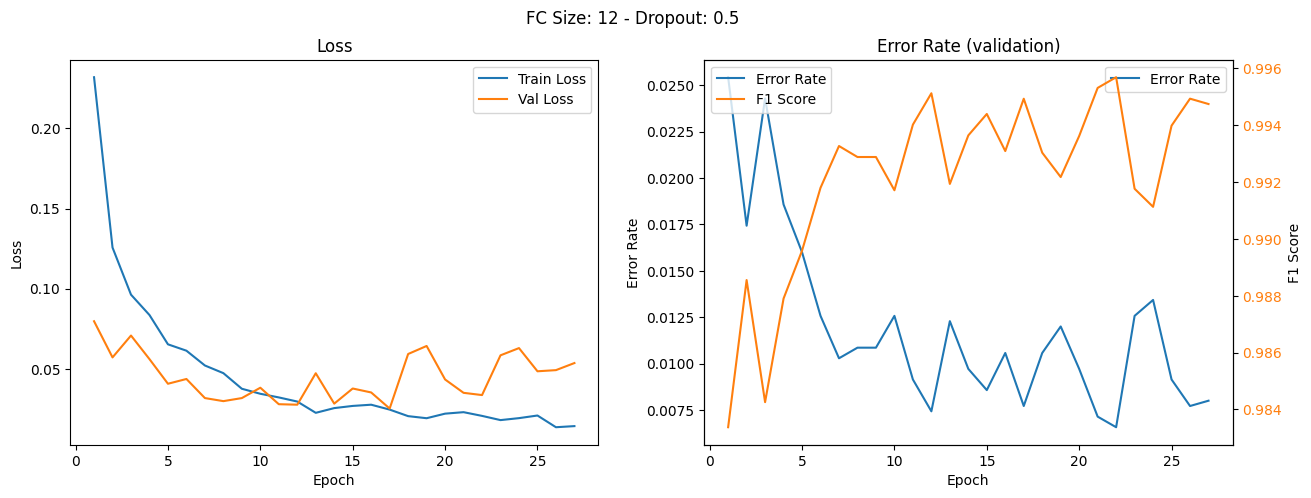

>>>>>>>>     FC Size: 24 - Dropout: 0.1     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2172 - Val Loss: 0.0767 - Error Rate: 0.0257 - F1 Score: 0.9830 - (FPR: 0.0099 - FNR: 0.0736)


Epoch 2/100	 Train Loss: 0.0890 - Val Loss: 0.0591 - Error Rate: 0.0237 - F1 Score: 0.9845 - (FPR: 0.0186 - FNR: 0.0405)


Epoch 3/100	 Train Loss: 0.0539 - Val Loss: 0.0568 - Error Rate: 0.0209 - F1 Score: 0.9865 - (FPR: 0.0239 - FNR: 0.0103)


Epoch 4/100	 Train Loss: 0.0488 - Val Loss: 0.0317 - Error Rate: 0.0106 - F1 Score: 0.9931 - (FPR: 0.0056 - FNR: 0.0262)


Epoch 5/100	 Train Loss: 0.0311 - Val Loss: 0.0329 - Error Rate: 0.0120 - F1 Score: 0.9921 - (FPR: 0.0079 - FNR: 0.0252)


Epoch 6/100	 Train Loss: 0.0244 - Val Loss: 0.0336 - Error Rate: 0.0103 - F1 Score: 0.9933 - (FPR: 0.0082 - FNR: 0.0170)


Epoch 7/100	 Train Loss: 0.0181 - Val Loss: 0.0256 - Error Rate: 0.0083 - F1 Score: 0.9946 - (FPR: 0.0052 - FNR: 0.0180)


Epoch 8/100	 Train Loss: 0.0156 - Val Loss: 0.0509 - Error Rate: 0.0171 - F1 Score: 0.9886 - (FPR: 0.0011 - FNR: 0.0643)


Epoch 9/100	 Train Loss: 0.0149 - Val Loss: 0.0304 - Error Rate: 0.0091 - F1 Score: 0.9940 - (FPR: 0.0049 - FNR: 0.0227)


Epoch 10/100	 Train Loss: 0.0135 - Val Loss: 0.0395 - Error Rate: 0.0109 - F1 Score: 0.9929 - (FPR: 0.0038 - FNR: 0.0329)


Epoch 11/100	 Train Loss: 0.0061 - Val Loss: 0.0965 - Error Rate: 0.0217 - F1 Score: 0.9856 - (FPR: 0.0012 - FNR: 0.0809)


Epoch 12/100	 Train Loss: 0.0105 - Val Loss: 0.0371 - Error Rate: 0.0114 - F1 Score: 0.9925 - (FPR: 0.0015 - FNR: 0.0417)


Epoch 13/100	 Train Loss: 0.0059 - Val Loss: 0.1116 - Error Rate: 0.0297 - F1 Score: 0.9808 - (FPR: 0.0358 - FNR: 0.0068)


Epoch 14/100	 Train Loss: 0.0140 - Val Loss: 0.0284 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0023 - FNR: 0.0259)


Epoch 15/100	 Train Loss: 0.0029 - Val Loss: 0.0505 - Error Rate: 0.0131 - F1 Score: 0.9913 - (FPR: 0.0042 - FNR: 0.0409)


Epoch 16/100	 Train Loss: 0.0033 - Val Loss: 0.0312 - Error Rate: 0.0077 - F1 Score: 0.9949 - (FPR: 0.0030 - FNR: 0.0225)


Epoch 17/100	 Train Loss: 0.0006 - Val Loss: 0.0560 - Error Rate: 0.0126 - F1 Score: 0.9917 - (FPR: 0.0011 - FNR: 0.0471)
Early stopping on epoch 17


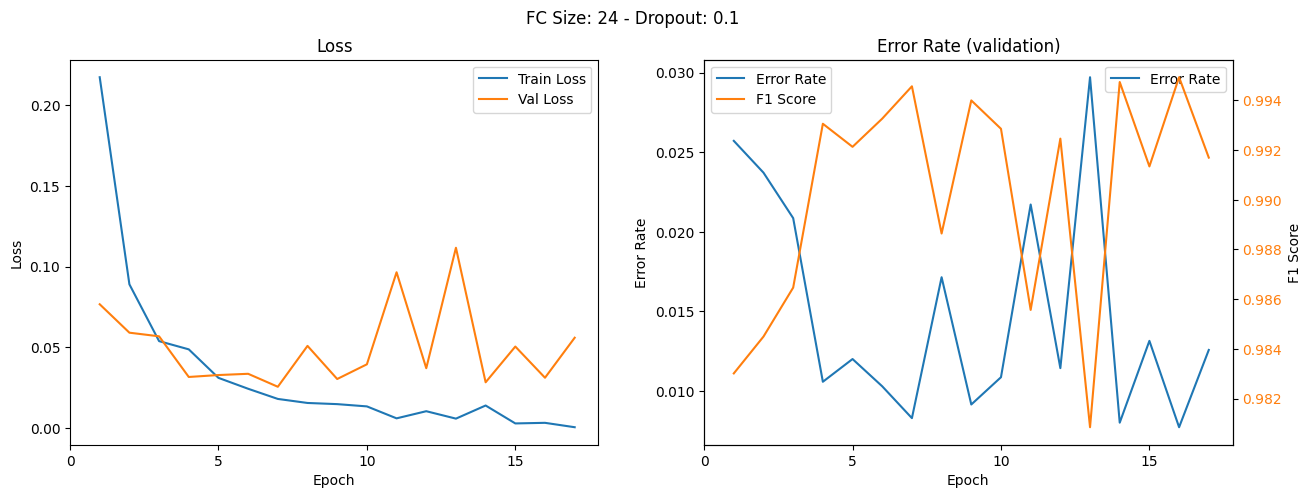

>>>>>>>>     FC Size: 24 - Dropout: 0.3     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2208 - Val Loss: 0.0819 - Error Rate: 0.0294 - F1 Score: 0.9808 - (FPR: 0.0259 - FNR: 0.0415)


Epoch 2/100	 Train Loss: 0.0897 - Val Loss: 0.0626 - Error Rate: 0.0209 - F1 Score: 0.9864 - (FPR: 0.0193 - FNR: 0.0262)


Epoch 3/100	 Train Loss: 0.0635 - Val Loss: 0.0419 - Error Rate: 0.0149 - F1 Score: 0.9903 - (FPR: 0.0097 - FNR: 0.0312)


Epoch 4/100	 Train Loss: 0.0541 - Val Loss: 0.0386 - Error Rate: 0.0126 - F1 Score: 0.9917 - (FPR: 0.0071 - FNR: 0.0298)


Epoch 5/100	 Train Loss: 0.0378 - Val Loss: 0.0309 - Error Rate: 0.0103 - F1 Score: 0.9933 - (FPR: 0.0097 - FNR: 0.0123)


Epoch 6/100	 Train Loss: 0.0292 - Val Loss: 0.0428 - Error Rate: 0.0143 - F1 Score: 0.9906 - (FPR: 0.0053 - FNR: 0.0422)


Epoch 7/100	 Train Loss: 0.0218 - Val Loss: 0.0262 - Error Rate: 0.0086 - F1 Score: 0.9944 - (FPR: 0.0075 - FNR: 0.0122)


Epoch 8/100	 Train Loss: 0.0214 - Val Loss: 0.0292 - Error Rate: 0.0120 - F1 Score: 0.9921 - (FPR: 0.0075 - FNR: 0.0264)


Epoch 9/100	 Train Loss: 0.0170 - Val Loss: 0.0253 - Error Rate: 0.0100 - F1 Score: 0.9934 - (FPR: 0.0067 - FNR: 0.0205)


Epoch 10/100	 Train Loss: 0.0106 - Val Loss: 0.0314 - Error Rate: 0.0109 - F1 Score: 0.9928 - (FPR: 0.0023 - FNR: 0.0373)


Epoch 11/100	 Train Loss: 0.0081 - Val Loss: 0.0417 - Error Rate: 0.0117 - F1 Score: 0.9923 - (FPR: 0.0030 - FNR: 0.0385)


Epoch 12/100	 Train Loss: 0.0072 - Val Loss: 0.0394 - Error Rate: 0.0120 - F1 Score: 0.9921 - (FPR: 0.0090 - FNR: 0.0218)


Epoch 13/100	 Train Loss: 0.0074 - Val Loss: 0.0320 - Error Rate: 0.0089 - F1 Score: 0.9942 - (FPR: 0.0030 - FNR: 0.0272)


Epoch 14/100	 Train Loss: 0.0105 - Val Loss: 0.0346 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0082 - FNR: 0.0134)


Epoch 15/100	 Train Loss: 0.0079 - Val Loss: 0.0289 - Error Rate: 0.0071 - F1 Score: 0.9953 - (FPR: 0.0060 - FNR: 0.0109)


Epoch 16/100	 Train Loss: 0.0051 - Val Loss: 0.0421 - Error Rate: 0.0123 - F1 Score: 0.9919 - (FPR: 0.0030 - FNR: 0.0407)


Epoch 17/100	 Train Loss: 0.0029 - Val Loss: 0.0261 - Error Rate: 0.0063 - F1 Score: 0.9959 - (FPR: 0.0034 - FNR: 0.0156)


Epoch 18/100	 Train Loss: 0.0019 - Val Loss: 0.0450 - Error Rate: 0.0111 - F1 Score: 0.9927 - (FPR: 0.0097 - FNR: 0.0159)


Epoch 19/100	 Train Loss: 0.0107 - Val Loss: 0.0355 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0041 - FNR: 0.0203)
Early stopping on epoch 19


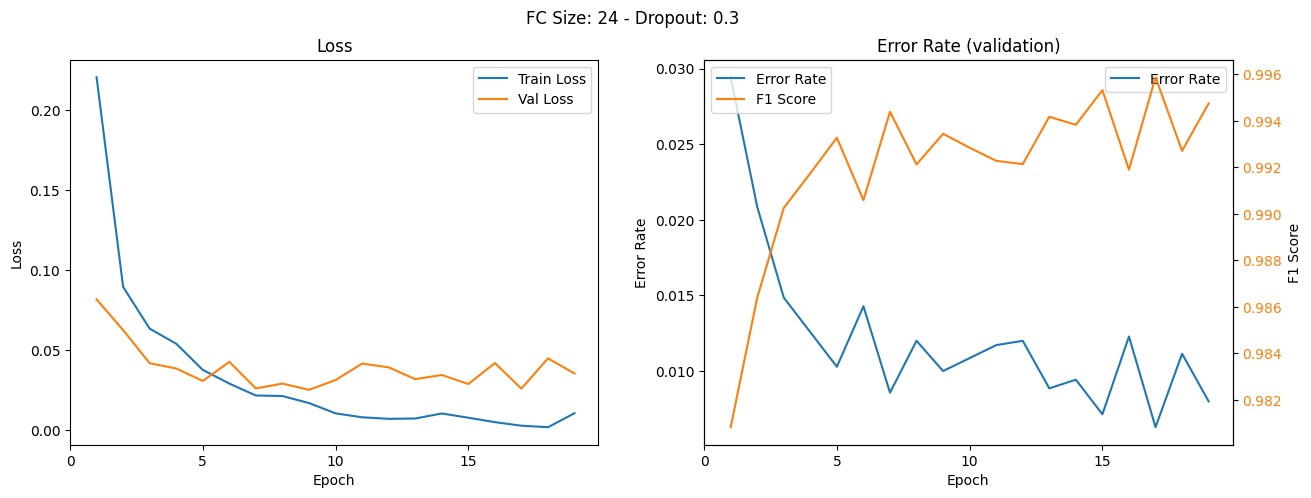

>>>>>>>>     FC Size: 24 - Dropout: 0.5     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2260 - Val Loss: 0.0804 - Error Rate: 0.0283 - F1 Score: 0.9812 - (FPR: 0.0073 - FNR: 0.0896)


Epoch 2/100	 Train Loss: 0.0898 - Val Loss: 0.0679 - Error Rate: 0.0231 - F1 Score: 0.9849 - (FPR: 0.0193 - FNR: 0.0358)


Epoch 3/100	 Train Loss: 0.0677 - Val Loss: 0.0469 - Error Rate: 0.0140 - F1 Score: 0.9908 - (FPR: 0.0086 - FNR: 0.0311)


Epoch 4/100	 Train Loss: 0.0542 - Val Loss: 0.0361 - Error Rate: 0.0126 - F1 Score: 0.9917 - (FPR: 0.0049 - FNR: 0.0365)


Epoch 5/100	 Train Loss: 0.0451 - Val Loss: 0.0389 - Error Rate: 0.0111 - F1 Score: 0.9927 - (FPR: 0.0060 - FNR: 0.0274)


Epoch 6/100	 Train Loss: 0.0357 - Val Loss: 0.0341 - Error Rate: 0.0103 - F1 Score: 0.9933 - (FPR: 0.0101 - FNR: 0.0111)


Epoch 7/100	 Train Loss: 0.0269 - Val Loss: 0.0326 - Error Rate: 0.0103 - F1 Score: 0.9933 - (FPR: 0.0097 - FNR: 0.0123)


Epoch 8/100	 Train Loss: 0.0232 - Val Loss: 0.0281 - Error Rate: 0.0091 - F1 Score: 0.9940 - (FPR: 0.0089 - FNR: 0.0098)


Epoch 9/100	 Train Loss: 0.0220 - Val Loss: 0.0351 - Error Rate: 0.0103 - F1 Score: 0.9933 - (FPR: 0.0067 - FNR: 0.0216)


Epoch 10/100	 Train Loss: 0.0178 - Val Loss: 0.0534 - Error Rate: 0.0137 - F1 Score: 0.9910 - (FPR: 0.0042 - FNR: 0.0431)


Epoch 11/100	 Train Loss: 0.0167 - Val Loss: 0.0387 - Error Rate: 0.0111 - F1 Score: 0.9927 - (FPR: 0.0049 - FNR: 0.0308)


Epoch 12/100	 Train Loss: 0.0142 - Val Loss: 0.0397 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0067 - FNR: 0.0181)


Epoch 13/100	 Train Loss: 0.0122 - Val Loss: 0.0383 - Error Rate: 0.0097 - F1 Score: 0.9936 - (FPR: 0.0097 - FNR: 0.0098)


Epoch 14/100	 Train Loss: 0.0049 - Val Loss: 0.0365 - Error Rate: 0.0089 - F1 Score: 0.9942 - (FPR: 0.0071 - FNR: 0.0145)


Epoch 15/100	 Train Loss: 0.0098 - Val Loss: 0.0515 - Error Rate: 0.0106 - F1 Score: 0.9930 - (FPR: 0.0041 - FNR: 0.0307)


Epoch 16/100	 Train Loss: 0.0077 - Val Loss: 0.0356 - Error Rate: 0.0109 - F1 Score: 0.9929 - (FPR: 0.0045 - FNR: 0.0307)


Epoch 17/100	 Train Loss: 0.0083 - Val Loss: 0.0432 - Error Rate: 0.0071 - F1 Score: 0.9953 - (FPR: 0.0064 - FNR: 0.0097)


Epoch 18/100	 Train Loss: 0.0023 - Val Loss: 0.0502 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0030 - FNR: 0.0237)
Early stopping on epoch 18


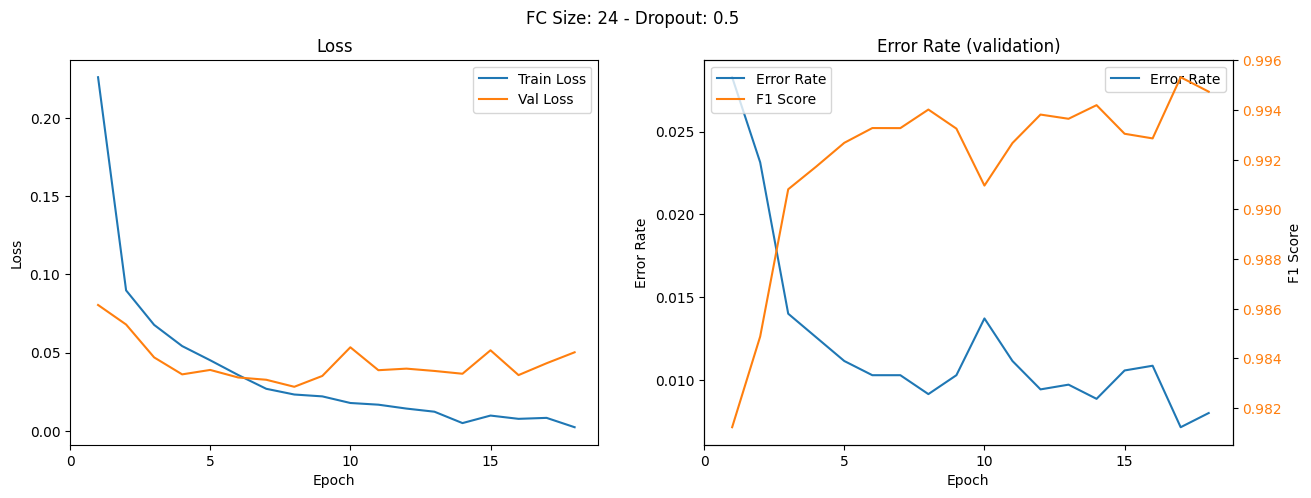

In [55]:
fc_sizes = [6, 12, 24]
dropouts = [0.1, 0.3, 0.5]
%matplotlib inline

best_models = []

for fc_size in fc_sizes:
    for dropout in dropouts:
        
        print(f'>>>>>>>>     FC Size: {fc_size} - Dropout: {dropout}     <<<<<<<<')
        # Create the model
        model = CustomConvNet(fc_size=fc_size, dropout=dropout).to(device)

        # Define the loss function and optimizer
        criterion = nn.BCEWithLogitsLoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # Create the dataloaders
        train_dataloader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_data, BATCH_SIZE, shuffle=False)

        train_losses = []
        val_losses = []
        err_rates = []
        f1_scores = []
        early_stopper = EarlyStopper(patience=10, min_delta=5e-4)
        best_epoch = None

        for epoch in range(EPOCHS):
            train_loss = train_model(train_dataloader, model, criterion, optimizer, checkpoint=False, desc=f'TrainingEpoch{(epoch + 1):02d}')
            val_loss, errors, confusion_matrix = evaluate(val_dataloader, model, criterion, desc=f'ValidationEpoch{(epoch + 1):02d}')
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            error_rate = (sum(errors) / len(val_data)).item()
            err_rates.append(error_rate)
            f1 = f1_score(confusion_matrix)
            f1_scores.append(f1)
            fpr = confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])
            fnr = confusion_matrix[1][0] / (confusion_matrix[1][0] + confusion_matrix[1][1])
            print(f'Epoch {epoch + 1}/{EPOCHS}\t Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Error Rate: {error_rate:.4f} - F1 Score: {f1:.4f} - (FPR: {fpr:.4f} - FNR: {fnr:.4f})')
            if best_epoch is None or val_loss < val_losses[best_epoch]:
                best_epoch = epoch
                save_checkpoint(model, optimizer, val_loss, f'custom3/fc_{fc_size}_dropout_{dropout}_lr_{LEARNING_RATE}', f'epoch{epoch+1}')

            if early_stopper.early_stop(val_loss):
                print(f'Early stopping on epoch {epoch + 1}')
                break
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f'FC Size: {fc_size} - Dropout: {dropout}')
        
        ax[0].set_title('Loss')
        ax[1].set_title('Error Rate (validation)')
        
        epochs = [i+1 for i in range(len(train_losses))]
        ax[0].plot(epochs, train_losses, label='Train Loss', color='tab:blue')
        ax[0].plot(epochs, val_losses, label='Val Loss', color='tab:orange')
        ax[1].plot(epochs, err_rates, label='Error Rate', color='tab:blue')
        ax2 = ax[1].twinx()
        ax2.plot(epochs, f1_scores, color='tab:orange', label='F1 Score')
        
        epochs = [i for i in range(0, len(train_losses)+1, 5)]
        ax[0].set_xlabel('Epoch')
        ax[0].set_xticks(epochs)
        ax[0].set_ylabel('Loss')
        ax[0].legend()
        ax[1].set_xlabel('Epoch')
        ax[1].set_xticks(epochs)
        ax[1].set_ylabel('Error Rate')
        ax[1].legend()
        ax2.set_ylabel('F1 Score')
        ax2.tick_params(axis='y', labelcolor='tab:orange')
        # Add legend
        lines, labels = ax[1].get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='best')

        plt.show()
        fig_dir = os.path.join(FIGURES_DIR, f'custom')
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
        fig_path = os.path.join(fig_dir, f'fc_{fc_size}_dropout_{dropout}_lr_{LEARNING_RATE}.png')
        
        fig.savefig(fig_path)

        best_models.append({
            'fc_size': fc_size,
            'dropout': dropout,
            'best_epoch': best_epoch,
            'train_loss': train_losses[best_epoch],
            'val_loss': val_losses[best_epoch],
            'error_rate': err_rates[best_epoch],
            'f1_score': f1_scores[best_epoch],
            'fig_path': fig_path,
        })

In [56]:
# model = CustomConvNet(fc_size=6, dropout=0.1).to(device)
# criterion = nn.BCEWithLogitsLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# model = load_checkpoint(model, optimizer, 'custom3/fc_6_dropout_0.1_lr_0.0005', 'epoch15')[0]

In [57]:
# # Define the path to the test annotations file and test image directory
# TEST_ANNO_FILE = DATA_PATH + 'sample_submission.csv'
# TEST_IMG_DIR = DATA_PATH + 'test/test/'

# # Create the test dataset object
# test_data = CactusDataset(TEST_ANNO_FILE, TEST_IMG_DIR, transform=transform)

# # Print the shape of the first image in the test dataset
# print(test_data[0][0].shape)

# # Create the test dataloader
# test_dataloader = torch.utils.data.DataLoader(test_data, BATCH_SIZE, shuffle=False)

# # Compute the predictions
# predictions = []
# model.eval()
# with torch.no_grad():
#     for X, _ in tqdm(test_dataloader, desc='Testing', leave=False):
#         X = X.to(device)
#         pred = model(X.float())
#         pred = nn.Sigmoid()(pred) > 0.5
#         predictions += pred.cpu().numpy().flatten().tolist()

In [58]:
# predictions = torch.tensor(predictions).int()

In [59]:
# print(predictions.shape)
# print(predictions.sum())
# tmp = torch.tensor(1) - predictions
# print(tmp.sum())

In [60]:
best_model = min(best_models, key=lambda x: x['val_loss'])

In [65]:
display(best_models)

[{'fc_size': 6,
  'dropout': 0.1,
  'best_epoch': 11,
  'train_loss': 0.02237098984100989,
  'val_loss': 0.027937237224940743,
  'error_rate': 0.0077142855152487755,
  'f1_score': 0.9949371835739733,
  'fig_path': 'figures/custom/fc_6_dropout_0.1_lr_0.001.png'},
 {'fc_size': 6,
  'dropout': 0.3,
  'best_epoch': 10,
  'train_loss': 0.10012026691436768,
  'val_loss': 0.01943970629785742,
  'error_rate': 0.0062857139855623245,
  'f1_score': 0.9958816922500936,
  'fig_path': 'figures/custom/fc_6_dropout_0.3_lr_0.001.png'},
 {'fc_size': 6,
  'dropout': 0.5,
  'best_epoch': 16,
  'train_loss': 0.15781220180647715,
  'val_loss': 0.02628169162784304,
  'error_rate': 0.008571428246796131,
  'f1_score': 0.9943735933983496,
  'fig_path': 'figures/custom/fc_6_dropout_0.5_lr_0.001.png'},
 {'fc_size': 12,
  'dropout': 0.1,
  'best_epoch': 6,
  'train_loss': 0.027462234123476915,
  'val_loss': 0.026653484723397663,
  'error_rate': 0.010285714641213417,
  'f1_score': 0.9932508436445444,
  'fig_path': 

In [64]:
display(best_model)

{'fc_size': 6,
 'dropout': 0.3,
 'best_epoch': 10,
 'train_loss': 0.10012026691436768,
 'val_loss': 0.01943970629785742,
 'error_rate': 0.0062857139855623245,
 'f1_score': 0.9958816922500936,
 'fig_path': 'figures/custom/fc_6_dropout_0.3_lr_0.001.png'}

In [66]:
from torchsummary import summary

model = CustomConvNet(fc_size=best_model['fc_size'], dropout=best_model['dropout']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model = load_checkpoint(model, optimizer, f'custom3/fc_{best_model["fc_size"]}_dropout_{best_model["dropout"]}_lr_{LEARNING_RATE}', f'epoch{best_model["best_epoch"]}')[0]
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
              ReLU-5             [-1, 64, 8, 8]               0
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Conv2d-7            [-1, 128, 2, 2]          73,856
              ReLU-8            [-1, 128, 2, 2]               0
         MaxPool2d-9            [-1, 128, 1, 1]               0
          Flatten-10                  [-1, 128]               0
           Linear-11                    [-1, 6]             774
             ReLU-12                    [-1, 6]               0
          Dropout-13                    [-1, 6]               0
           Linear-14                   

In [67]:
from torchviz import make_dot

# Generate a visualization of the network architecture
x = torch.randn(1, 3, 32, 32).to(device)  # Example input tensor with shape (batch_size, channels, height, width)
y = model(x)
make_dot(y, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render("custom_convnet", format="png")

'custom_convnet.png'

In [69]:
torch.onnx.export(model, x, "custom_convnet.onnx", export_params=True, opset_version=10, verbose=True)

Exported graph: graph(%input.1 : Float(1, 3, 32, 32, strides=[3072, 1024, 32, 1], requires_grad=0, device=cuda:0),
      %layer1.0.weight : Float(32, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=1, device=cuda:0),
      %layer1.0.bias : Float(32, strides=[1], requires_grad=1, device=cuda:0),
      %layer2.0.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cuda:0),
      %layer2.0.bias : Float(64, strides=[1], requires_grad=1, device=cuda:0),
      %layer3.0.weight : Float(128, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=1, device=cuda:0),
      %layer3.0.bias : Float(128, strides=[1], requires_grad=1, device=cuda:0),
      %fc1.weight : Float(6, 128, strides=[128, 1], requires_grad=1, device=cuda:0),
      %fc1.bias : Float(6, strides=[1], requires_grad=1, device=cuda:0),
      %fc2.weight : Float(1, 6, strides=[6, 1], requires_grad=1, device=cuda:0),
      %fc2.bias : Float(1, strides=[1], requires_grad=1, device=cuda:0)):
  %/layer1/layer1.0/Conv_outp

In [71]:
seeds = [27, 5, 89, 43, 11, 63, 18, 9, 36, 72]
fc_size = 6
dropout = 0.3

best_epochs = []
train_losses = []
val_losses = []
err_rates = []
f1_scores = []

for seed in seeds:
    torch.manual_seed(seed)
    train_data, val_data = random_split(trainval_data, [train_size, val_size])
    print(f'>>>>>>>>     FC Size: 6 - Dropout: 0.3 - seed: {seed}     <<<<<<<<')
    # Create the model
    model = CustomConvNet(fc_size=fc_size, dropout=dropout).to(device)

    # Define the loss function and optimizer
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Create the dataloaders
    train_dataloader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, BATCH_SIZE, shuffle=False)

    early_stopper = EarlyStopper(patience=10, min_delta=5e-4)
    best_epoch = None
    best_train_loss = None
    best_val_loss = None
    bst_err_rate = None
    best_f1 = None

    for epoch in range(EPOCHS):
        train_loss = train_model(train_dataloader, model, criterion, optimizer, checkpoint=False, desc=f'TrainingEpoch{(epoch + 1):02d}')
        val_loss, errors, confusion_matrix = evaluate(val_dataloader, model, criterion, desc=f'ValidationEpoch{(epoch + 1):02d}')
        error_rate = (sum(errors) / len(val_data)).item()
        f1 = f1_score(confusion_matrix)
        fpr = confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])
        fnr = confusion_matrix[1][0] / (confusion_matrix[1][0] + confusion_matrix[1][1])
        print(f'Epoch {epoch + 1}/{EPOCHS}\t Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Error Rate: {error_rate:.4f} - F1 Score: {f1:.4f} - (FPR: {fpr:.4f} - FNR: {fnr:.4f})')
        if best_epoch is None or val_loss < best_val_loss:
            best_epoch = epoch
            best_train_loss = train_loss
            best_val_loss = val_loss
            best_err_rate = error_rate
            best_f1 = f1
        if early_stopper.early_stop(val_loss):
            print(f'Early stopping on epoch {epoch + 1}')
            break
    
    best_epochs.append(best_epoch)
    train_losses.append(best_train_loss)
    val_losses.append(best_val_loss)
    err_rates.append(best_err_rate)
    f1_scores.append(best_f1)
    
avg_epoch = sum(best_epochs) / len(best_epochs)
avg_train_loss = sum(train_losses) / len(train_losses)
avg_val_loss = sum(val_losses) / len(val_losses)
avg_err_rate = sum(err_rates) / len(err_rates)
avg_f1 = sum(f1_scores) / len(f1_scores)

print(f'Average epoch: {avg_epoch:.2f}')
print(f'Average train loss: {avg_train_loss:.4f}')
print(f'Average val loss: {avg_val_loss:.4f}')
print(f'Average error rate: {avg_err_rate:.4f}')
print(f'Average F1 score: {avg_f1:.4f}')

>>>>>>>>     FC Size: 6 - Dropout: 0.3 - seed: 27     <<<<<<<<


TrainingEpoch01:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 1/100	 Train Loss: 0.3622 - Val Loss: 0.1009 - Error Rate: 0.0360 - F1 Score: 0.9763 - (FPR: 0.0226 - FNR: 0.0786)


Epoch 2/100	 Train Loss: 0.2197 - Val Loss: 0.0946 - Error Rate: 0.0363 - F1 Score: 0.9765 - (FPR: 0.0379 - FNR: 0.0305)


Epoch 3/100	 Train Loss: 0.1893 - Val Loss: 0.0701 - Error Rate: 0.0317 - F1 Score: 0.9795 - (FPR: 0.0349 - FNR: 0.0199)


Epoch 4/100	 Train Loss: 0.1656 - Val Loss: 0.0556 - Error Rate: 0.0229 - F1 Score: 0.9851 - (FPR: 0.0208 - FNR: 0.0299)


Epoch 5/100	 Train Loss: 0.1405 - Val Loss: 0.0580 - Error Rate: 0.0180 - F1 Score: 0.9881 - (FPR: 0.0046 - FNR: 0.0584)


Epoch 6/100	 Train Loss: 0.1193 - Val Loss: 0.0640 - Error Rate: 0.0289 - F1 Score: 0.9814 - (FPR: 0.0341 - FNR: 0.0094)


Epoch 7/100	 Train Loss: 0.0975 - Val Loss: 0.0400 - Error Rate: 0.0131 - F1 Score: 0.9914 - (FPR: 0.0086 - FNR: 0.0276)


Epoch 8/100	 Train Loss: 0.0849 - Val Loss: 0.0439 - Error Rate: 0.0137 - F1 Score: 0.9910 - (FPR: 0.0057 - FNR: 0.0387)


Epoch 9/100	 Train Loss: 0.0771 - Val Loss: 0.0323 - Error Rate: 0.0100 - F1 Score: 0.9934 - (FPR: 0.0053 - FNR: 0.0250)


Epoch 10/100	 Train Loss: 0.0692 - Val Loss: 0.0330 - Error Rate: 0.0100 - F1 Score: 0.9934 - (FPR: 0.0053 - FNR: 0.0250)


Epoch 11/100	 Train Loss: 0.0638 - Val Loss: 0.0323 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0071 - FNR: 0.0169)


Epoch 12/100	 Train Loss: 0.0530 - Val Loss: 0.0369 - Error Rate: 0.0117 - F1 Score: 0.9923 - (FPR: 0.0104 - FNR: 0.0159)


Epoch 13/100	 Train Loss: 0.0469 - Val Loss: 0.0823 - Error Rate: 0.0174 - F1 Score: 0.9885 - (FPR: 0.0034 - FNR: 0.0593)


Epoch 14/100	 Train Loss: 0.0522 - Val Loss: 0.0377 - Error Rate: 0.0109 - F1 Score: 0.9929 - (FPR: 0.0079 - FNR: 0.0205)


Epoch 15/100	 Train Loss: 0.0378 - Val Loss: 0.0357 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0045 - FNR: 0.0191)


Epoch 16/100	 Train Loss: 0.0356 - Val Loss: 0.0414 - Error Rate: 0.0109 - F1 Score: 0.9929 - (FPR: 0.0101 - FNR: 0.0134)


Epoch 17/100	 Train Loss: 0.0380 - Val Loss: 0.0524 - Error Rate: 0.0097 - F1 Score: 0.9936 - (FPR: 0.0026 - FNR: 0.0316)


Epoch 18/100	 Train Loss: 0.0346 - Val Loss: 0.0343 - Error Rate: 0.0100 - F1 Score: 0.9934 - (FPR: 0.0079 - FNR: 0.0169)


Epoch 19/100	 Train Loss: 0.0245 - Val Loss: 0.0476 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0038 - FNR: 0.0214)


Epoch 20/100	 Train Loss: 0.0279 - Val Loss: 0.0646 - Error Rate: 0.0106 - F1 Score: 0.9930 - (FPR: 0.0041 - FNR: 0.0306)
Early stopping on epoch 20
>>>>>>>>     FC Size: 6 - Dropout: 0.3 - seed: 5     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2384 - Val Loss: 0.1014 - Error Rate: 0.0394 - F1 Score: 0.9736 - (FPR: 0.0155 - FNR: 0.1069)


Epoch 2/100	 Train Loss: 0.1238 - Val Loss: 0.0778 - Error Rate: 0.0331 - F1 Score: 0.9782 - (FPR: 0.0273 - FNR: 0.0519)


Epoch 3/100	 Train Loss: 0.1030 - Val Loss: 0.0710 - Error Rate: 0.0274 - F1 Score: 0.9818 - (FPR: 0.0174 - FNR: 0.0579)


Epoch 4/100	 Train Loss: 0.0844 - Val Loss: 0.0483 - Error Rate: 0.0177 - F1 Score: 0.9882 - (FPR: 0.0106 - FNR: 0.0393)


Epoch 5/100	 Train Loss: 0.0781 - Val Loss: 0.0457 - Error Rate: 0.0169 - F1 Score: 0.9889 - (FPR: 0.0161 - FNR: 0.0192)


Epoch 6/100	 Train Loss: 0.0660 - Val Loss: 0.0393 - Error Rate: 0.0151 - F1 Score: 0.9899 - (FPR: 0.0050 - FNR: 0.0451)


Epoch 7/100	 Train Loss: 0.0665 - Val Loss: 0.0311 - Error Rate: 0.0120 - F1 Score: 0.9920 - (FPR: 0.0061 - FNR: 0.0299)


Epoch 8/100	 Train Loss: 0.0506 - Val Loss: 0.0629 - Error Rate: 0.0211 - F1 Score: 0.9862 - (FPR: 0.0262 - FNR: 0.0038)


Epoch 9/100	 Train Loss: 0.0546 - Val Loss: 0.0329 - Error Rate: 0.0109 - F1 Score: 0.9928 - (FPR: 0.0061 - FNR: 0.0254)


Epoch 10/100	 Train Loss: 0.0500 - Val Loss: 0.0279 - Error Rate: 0.0091 - F1 Score: 0.9939 - (FPR: 0.0042 - FNR: 0.0242)


Epoch 11/100	 Train Loss: 0.0438 - Val Loss: 0.0329 - Error Rate: 0.0120 - F1 Score: 0.9920 - (FPR: 0.0023 - FNR: 0.0405)


Epoch 12/100	 Train Loss: 0.0452 - Val Loss: 0.0398 - Error Rate: 0.0131 - F1 Score: 0.9913 - (FPR: 0.0150 - FNR: 0.0073)


Epoch 13/100	 Train Loss: 0.0399 - Val Loss: 0.0342 - Error Rate: 0.0074 - F1 Score: 0.9951 - (FPR: 0.0075 - FNR: 0.0071)


Epoch 14/100	 Train Loss: 0.0390 - Val Loss: 0.0231 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0053 - FNR: 0.0163)


Epoch 15/100	 Train Loss: 0.0423 - Val Loss: 0.0381 - Error Rate: 0.0103 - F1 Score: 0.9931 - (FPR: 0.0011 - FNR: 0.0371)


Epoch 16/100	 Train Loss: 0.0380 - Val Loss: 0.0426 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0101 - FNR: 0.0072)


Epoch 17/100	 Train Loss: 0.0401 - Val Loss: 0.0402 - Error Rate: 0.0129 - F1 Score: 0.9915 - (FPR: 0.0076 - FNR: 0.0289)


Epoch 18/100	 Train Loss: 0.0356 - Val Loss: 0.0434 - Error Rate: 0.0106 - F1 Score: 0.9930 - (FPR: 0.0113 - FNR: 0.0084)


Epoch 19/100	 Train Loss: 0.0310 - Val Loss: 0.0392 - Error Rate: 0.0100 - F1 Score: 0.9934 - (FPR: 0.0094 - FNR: 0.0118)


Epoch 20/100	 Train Loss: 0.0348 - Val Loss: 0.0409 - Error Rate: 0.0126 - F1 Score: 0.9917 - (FPR: 0.0131 - FNR: 0.0108)


Epoch 21/100	 Train Loss: 0.0429 - Val Loss: 0.0271 - Error Rate: 0.0083 - F1 Score: 0.9945 - (FPR: 0.0042 - FNR: 0.0208)


Epoch 22/100	 Train Loss: 0.0391 - Val Loss: 0.0307 - Error Rate: 0.0100 - F1 Score: 0.9934 - (FPR: 0.0049 - FNR: 0.0253)


Epoch 23/100	 Train Loss: 0.0312 - Val Loss: 0.0345 - Error Rate: 0.0106 - F1 Score: 0.9930 - (FPR: 0.0105 - FNR: 0.0107)


Epoch 24/100	 Train Loss: 0.0305 - Val Loss: 0.0520 - Error Rate: 0.0097 - F1 Score: 0.9936 - (FPR: 0.0046 - FNR: 0.0253)
Early stopping on epoch 24
>>>>>>>>     FC Size: 6 - Dropout: 0.3 - seed: 89     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2286 - Val Loss: 0.1068 - Error Rate: 0.0389 - F1 Score: 0.9739 - (FPR: 0.0257 - FNR: 0.0772)


Epoch 2/100	 Train Loss: 0.1255 - Val Loss: 0.1092 - Error Rate: 0.0423 - F1 Score: 0.9714 - (FPR: 0.0221 - FNR: 0.0983)


Epoch 3/100	 Train Loss: 0.1100 - Val Loss: 0.0993 - Error Rate: 0.0380 - F1 Score: 0.9749 - (FPR: 0.0408 - FNR: 0.0286)


Epoch 4/100	 Train Loss: 0.0939 - Val Loss: 0.0836 - Error Rate: 0.0314 - F1 Score: 0.9792 - (FPR: 0.0319 - FNR: 0.0300)


Epoch 5/100	 Train Loss: 0.0816 - Val Loss: 0.0596 - Error Rate: 0.0194 - F1 Score: 0.9869 - (FPR: 0.0058 - FNR: 0.0570)


Epoch 6/100	 Train Loss: 0.0724 - Val Loss: 0.0530 - Error Rate: 0.0191 - F1 Score: 0.9872 - (FPR: 0.0182 - FNR: 0.0220)


Epoch 7/100	 Train Loss: 0.0665 - Val Loss: 0.0516 - Error Rate: 0.0160 - F1 Score: 0.9893 - (FPR: 0.0126 - FNR: 0.0261)


Epoch 8/100	 Train Loss: 0.0647 - Val Loss: 0.0608 - Error Rate: 0.0197 - F1 Score: 0.9867 - (FPR: 0.0089 - FNR: 0.0503)


Epoch 9/100	 Train Loss: 0.0567 - Val Loss: 0.0444 - Error Rate: 0.0129 - F1 Score: 0.9913 - (FPR: 0.0035 - FNR: 0.0392)


Epoch 10/100	 Train Loss: 0.0578 - Val Loss: 0.0402 - Error Rate: 0.0103 - F1 Score: 0.9931 - (FPR: 0.0061 - FNR: 0.0223)


Epoch 11/100	 Train Loss: 0.0454 - Val Loss: 0.0495 - Error Rate: 0.0137 - F1 Score: 0.9907 - (FPR: 0.0023 - FNR: 0.0453)


Epoch 12/100	 Train Loss: 0.0446 - Val Loss: 0.0342 - Error Rate: 0.0106 - F1 Score: 0.9929 - (FPR: 0.0054 - FNR: 0.0255)


Epoch 13/100	 Train Loss: 0.0448 - Val Loss: 0.0411 - Error Rate: 0.0109 - F1 Score: 0.9927 - (FPR: 0.0088 - FNR: 0.0170)


Epoch 14/100	 Train Loss: 0.0447 - Val Loss: 0.0463 - Error Rate: 0.0109 - F1 Score: 0.9927 - (FPR: 0.0084 - FNR: 0.0181)


Epoch 15/100	 Train Loss: 0.0392 - Val Loss: 0.0600 - Error Rate: 0.0143 - F1 Score: 0.9904 - (FPR: 0.0054 - FNR: 0.0394)


Epoch 16/100	 Train Loss: 0.0368 - Val Loss: 0.0538 - Error Rate: 0.0131 - F1 Score: 0.9912 - (FPR: 0.0137 - FNR: 0.0115)


Epoch 17/100	 Train Loss: 0.0378 - Val Loss: 0.0576 - Error Rate: 0.0123 - F1 Score: 0.9917 - (FPR: 0.0043 - FNR: 0.0350)


Epoch 18/100	 Train Loss: 0.0348 - Val Loss: 0.0694 - Error Rate: 0.0149 - F1 Score: 0.9899 - (FPR: 0.0019 - FNR: 0.0503)


Epoch 19/100	 Train Loss: 0.0398 - Val Loss: 0.0639 - Error Rate: 0.0157 - F1 Score: 0.9895 - (FPR: 0.0178 - FNR: 0.0094)


Epoch 20/100	 Train Loss: 0.0336 - Val Loss: 0.0504 - Error Rate: 0.0100 - F1 Score: 0.9933 - (FPR: 0.0073 - FNR: 0.0180)


Epoch 21/100	 Train Loss: 0.0296 - Val Loss: 0.0613 - Error Rate: 0.0097 - F1 Score: 0.9935 - (FPR: 0.0069 - FNR: 0.0180)


Epoch 22/100	 Train Loss: 0.0294 - Val Loss: 0.0877 - Error Rate: 0.0163 - F1 Score: 0.9891 - (FPR: 0.0148 - FNR: 0.0207)
Early stopping on epoch 22
>>>>>>>>     FC Size: 6 - Dropout: 0.3 - seed: 43     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2385 - Val Loss: 0.0906 - Error Rate: 0.0274 - F1 Score: 0.9818 - (FPR: 0.0171 - FNR: 0.0590)


Epoch 2/100	 Train Loss: 0.0980 - Val Loss: 0.0740 - Error Rate: 0.0254 - F1 Score: 0.9833 - (FPR: 0.0264 - FNR: 0.0223)


Epoch 3/100	 Train Loss: 0.0814 - Val Loss: 0.1010 - Error Rate: 0.0386 - F1 Score: 0.9739 - (FPR: 0.0055 - FNR: 0.1253)


Epoch 4/100	 Train Loss: 0.0675 - Val Loss: 0.0565 - Error Rate: 0.0194 - F1 Score: 0.9870 - (FPR: 0.0054 - FNR: 0.0601)


Epoch 5/100	 Train Loss: 0.0580 - Val Loss: 0.0463 - Error Rate: 0.0154 - F1 Score: 0.9898 - (FPR: 0.0154 - FNR: 0.0156)


Epoch 6/100	 Train Loss: 0.0545 - Val Loss: 0.0379 - Error Rate: 0.0109 - F1 Score: 0.9928 - (FPR: 0.0053 - FNR: 0.0276)


Epoch 7/100	 Train Loss: 0.0451 - Val Loss: 0.0437 - Error Rate: 0.0137 - F1 Score: 0.9909 - (FPR: 0.0117 - FNR: 0.0201)


Epoch 8/100	 Train Loss: 0.0422 - Val Loss: 0.0448 - Error Rate: 0.0131 - F1 Score: 0.9912 - (FPR: 0.0019 - FNR: 0.0458)


Epoch 9/100	 Train Loss: 0.0367 - Val Loss: 0.0437 - Error Rate: 0.0131 - F1 Score: 0.9912 - (FPR: 0.0038 - FNR: 0.0407)


Epoch 10/100	 Train Loss: 0.0331 - Val Loss: 0.0440 - Error Rate: 0.0123 - F1 Score: 0.9919 - (FPR: 0.0131 - FNR: 0.0096)


Epoch 11/100	 Train Loss: 0.0314 - Val Loss: 0.0341 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0090 - FNR: 0.0107)


Epoch 12/100	 Train Loss: 0.0281 - Val Loss: 0.0548 - Error Rate: 0.0146 - F1 Score: 0.9904 - (FPR: 0.0106 - FNR: 0.0269)


Epoch 13/100	 Train Loss: 0.0323 - Val Loss: 0.0370 - Error Rate: 0.0106 - F1 Score: 0.9930 - (FPR: 0.0038 - FNR: 0.0308)


Epoch 14/100	 Train Loss: 0.0273 - Val Loss: 0.0398 - Error Rate: 0.0126 - F1 Score: 0.9917 - (FPR: 0.0098 - FNR: 0.0212)


Epoch 15/100	 Train Loss: 0.0206 - Val Loss: 0.0422 - Error Rate: 0.0097 - F1 Score: 0.9936 - (FPR: 0.0094 - FNR: 0.0107)


Epoch 16/100	 Train Loss: 0.0224 - Val Loss: 0.0433 - Error Rate: 0.0077 - F1 Score: 0.9949 - (FPR: 0.0057 - FNR: 0.0140)


Epoch 17/100	 Train Loss: 0.0190 - Val Loss: 0.0526 - Error Rate: 0.0086 - F1 Score: 0.9943 - (FPR: 0.0030 - FNR: 0.0252)


Epoch 18/100	 Train Loss: 0.0167 - Val Loss: 0.0887 - Error Rate: 0.0131 - F1 Score: 0.9913 - (FPR: 0.0139 - FNR: 0.0108)


Epoch 19/100	 Train Loss: 0.0255 - Val Loss: 0.0579 - Error Rate: 0.0143 - F1 Score: 0.9905 - (FPR: 0.0038 - FNR: 0.0450)


Epoch 20/100	 Train Loss: 0.0314 - Val Loss: 0.0319 - Error Rate: 0.0103 - F1 Score: 0.9932 - (FPR: 0.0038 - FNR: 0.0297)


Epoch 21/100	 Train Loss: 0.0212 - Val Loss: 0.0335 - Error Rate: 0.0071 - F1 Score: 0.9953 - (FPR: 0.0053 - FNR: 0.0129)


Epoch 22/100	 Train Loss: 0.0176 - Val Loss: 0.0433 - Error Rate: 0.0086 - F1 Score: 0.9943 - (FPR: 0.0027 - FNR: 0.0263)


Epoch 23/100	 Train Loss: 0.0156 - Val Loss: 0.0575 - Error Rate: 0.0094 - F1 Score: 0.9937 - (FPR: 0.0034 - FNR: 0.0275)


Epoch 24/100	 Train Loss: 0.0291 - Val Loss: 0.0737 - Error Rate: 0.0149 - F1 Score: 0.9902 - (FPR: 0.0164 - FNR: 0.0097)


Epoch 25/100	 Train Loss: 0.0204 - Val Loss: 0.0433 - Error Rate: 0.0086 - F1 Score: 0.9943 - (FPR: 0.0057 - FNR: 0.0175)


Epoch 26/100	 Train Loss: 0.0193 - Val Loss: 0.0530 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0030 - FNR: 0.0230)


Epoch 27/100	 Train Loss: 0.0162 - Val Loss: 0.0650 - Error Rate: 0.0077 - F1 Score: 0.9949 - (FPR: 0.0038 - FNR: 0.0196)


Epoch 28/100	 Train Loss: 0.0143 - Val Loss: 0.0692 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0046 - FNR: 0.0185)


Epoch 29/100	 Train Loss: 0.0179 - Val Loss: 0.4668 - Error Rate: 0.0797 - F1 Score: 0.9443 - (FPR: 0.0017 - FNR: 0.2434)


Epoch 30/100	 Train Loss: 0.0318 - Val Loss: 0.0694 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0068 - FNR: 0.0175)
Early stopping on epoch 30
>>>>>>>>     FC Size: 6 - Dropout: 0.3 - seed: 11     <<<<<<<<


Epoch 1/100	 Train Loss: 0.3247 - Val Loss: 0.2172 - Error Rate: 0.0346 - F1 Score: 0.9775 - (FPR: 0.0328 - FNR: 0.0408)


Epoch 2/100	 Train Loss: 0.2563 - Val Loss: 0.1020 - Error Rate: 0.0229 - F1 Score: 0.9850 - (FPR: 0.0187 - FNR: 0.0365)


Epoch 3/100	 Train Loss: 0.1848 - Val Loss: 0.0825 - Error Rate: 0.0249 - F1 Score: 0.9836 - (FPR: 0.0144 - FNR: 0.0574)


Epoch 4/100	 Train Loss: 0.1451 - Val Loss: 0.0599 - Error Rate: 0.0194 - F1 Score: 0.9873 - (FPR: 0.0172 - FNR: 0.0269)


Epoch 5/100	 Train Loss: 0.1419 - Val Loss: 0.0513 - Error Rate: 0.0154 - F1 Score: 0.9898 - (FPR: 0.0038 - FNR: 0.0502)


Epoch 6/100	 Train Loss: 0.1335 - Val Loss: 0.0499 - Error Rate: 0.0163 - F1 Score: 0.9893 - (FPR: 0.0164 - FNR: 0.0160)


Epoch 7/100	 Train Loss: 0.1289 - Val Loss: 0.0584 - Error Rate: 0.0157 - F1 Score: 0.9897 - (FPR: 0.0156 - FNR: 0.0160)


Epoch 8/100	 Train Loss: 0.1217 - Val Loss: 0.0368 - Error Rate: 0.0100 - F1 Score: 0.9934 - (FPR: 0.0057 - FNR: 0.0236)


Epoch 9/100	 Train Loss: 0.1178 - Val Loss: 0.0516 - Error Rate: 0.0146 - F1 Score: 0.9904 - (FPR: 0.0134 - FNR: 0.0183)


Epoch 10/100	 Train Loss: 0.1122 - Val Loss: 0.0380 - Error Rate: 0.0106 - F1 Score: 0.9931 - (FPR: 0.0097 - FNR: 0.0133)


Epoch 11/100	 Train Loss: 0.1100 - Val Loss: 0.0385 - Error Rate: 0.0111 - F1 Score: 0.9927 - (FPR: 0.0101 - FNR: 0.0145)


Epoch 12/100	 Train Loss: 0.1056 - Val Loss: 0.0581 - Error Rate: 0.0151 - F1 Score: 0.9901 - (FPR: 0.0171 - FNR: 0.0087)


Epoch 13/100	 Train Loss: 0.1054 - Val Loss: 0.0393 - Error Rate: 0.0091 - F1 Score: 0.9940 - (FPR: 0.0090 - FNR: 0.0097)


Epoch 14/100	 Train Loss: 0.1057 - Val Loss: 0.0596 - Error Rate: 0.0114 - F1 Score: 0.9925 - (FPR: 0.0119 - FNR: 0.0098)


Epoch 15/100	 Train Loss: 0.1065 - Val Loss: 0.0479 - Error Rate: 0.0103 - F1 Score: 0.9932 - (FPR: 0.0094 - FNR: 0.0133)


Epoch 16/100	 Train Loss: 0.1044 - Val Loss: 0.0351 - Error Rate: 0.0083 - F1 Score: 0.9945 - (FPR: 0.0053 - FNR: 0.0178)


Epoch 17/100	 Train Loss: 0.1030 - Val Loss: 0.0350 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0053 - FNR: 0.0224)


Epoch 18/100	 Train Loss: 0.1024 - Val Loss: 0.0543 - Error Rate: 0.0114 - F1 Score: 0.9925 - (FPR: 0.0086 - FNR: 0.0203)


Epoch 19/100	 Train Loss: 0.1077 - Val Loss: 0.0525 - Error Rate: 0.0106 - F1 Score: 0.9931 - (FPR: 0.0090 - FNR: 0.0156)


Epoch 20/100	 Train Loss: 0.1019 - Val Loss: 0.0351 - Error Rate: 0.0100 - F1 Score: 0.9934 - (FPR: 0.0023 - FNR: 0.0335)


Epoch 21/100	 Train Loss: 0.1012 - Val Loss: 0.0406 - Error Rate: 0.0074 - F1 Score: 0.9951 - (FPR: 0.0056 - FNR: 0.0131)


Epoch 22/100	 Train Loss: 0.0989 - Val Loss: 0.0505 - Error Rate: 0.0086 - F1 Score: 0.9944 - (FPR: 0.0071 - FNR: 0.0132)


Epoch 23/100	 Train Loss: 0.1023 - Val Loss: 0.0481 - Error Rate: 0.0083 - F1 Score: 0.9946 - (FPR: 0.0071 - FNR: 0.0120)


Epoch 24/100	 Train Loss: 0.0984 - Val Loss: 0.0444 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0026 - FNR: 0.0245)


Epoch 25/100	 Train Loss: 0.1043 - Val Loss: 0.0439 - Error Rate: 0.0089 - F1 Score: 0.9942 - (FPR: 0.0038 - FNR: 0.0246)


Epoch 26/100	 Train Loss: 0.1025 - Val Loss: 0.0373 - Error Rate: 0.0109 - F1 Score: 0.9928 - (FPR: 0.0019 - FNR: 0.0379)


Epoch 27/100	 Train Loss: 0.0993 - Val Loss: 0.0526 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0053 - FNR: 0.0224)


Epoch 28/100	 Train Loss: 0.1046 - Val Loss: 0.0455 - Error Rate: 0.0091 - F1 Score: 0.9940 - (FPR: 0.0056 - FNR: 0.0201)
Early stopping on epoch 28
>>>>>>>>     FC Size: 6 - Dropout: 0.3 - seed: 63     <<<<<<<<


Epoch 1/100	 Train Loss: 0.3534 - Val Loss: 0.1250 - Error Rate: 0.0500 - F1 Score: 0.9675 - (FPR: 0.0520 - FNR: 0.0427)


Epoch 2/100	 Train Loss: 0.2294 - Val Loss: 0.0886 - Error Rate: 0.0300 - F1 Score: 0.9803 - (FPR: 0.0297 - FNR: 0.0311)


Epoch 3/100	 Train Loss: 0.1928 - Val Loss: 0.0825 - Error Rate: 0.0357 - F1 Score: 0.9766 - (FPR: 0.0348 - FNR: 0.0389)


Epoch 4/100	 Train Loss: 0.1687 - Val Loss: 0.0671 - Error Rate: 0.0291 - F1 Score: 0.9809 - (FPR: 0.0290 - FNR: 0.0298)


Epoch 5/100	 Train Loss: 0.1580 - Val Loss: 0.0632 - Error Rate: 0.0274 - F1 Score: 0.9821 - (FPR: 0.0310 - FNR: 0.0152)


Epoch 6/100	 Train Loss: 0.1371 - Val Loss: 0.0458 - Error Rate: 0.0154 - F1 Score: 0.9898 - (FPR: 0.0132 - FNR: 0.0225)


Epoch 7/100	 Train Loss: 0.1191 - Val Loss: 0.0546 - Error Rate: 0.0154 - F1 Score: 0.9897 - (FPR: 0.0027 - FNR: 0.0522)


Epoch 8/100	 Train Loss: 0.1186 - Val Loss: 0.0594 - Error Rate: 0.0260 - F1 Score: 0.9830 - (FPR: 0.0323 - FNR: 0.0039)


Epoch 9/100	 Train Loss: 0.1141 - Val Loss: 0.0419 - Error Rate: 0.0169 - F1 Score: 0.9889 - (FPR: 0.0179 - FNR: 0.0134)


Epoch 10/100	 Train Loss: 0.0986 - Val Loss: 0.0381 - Error Rate: 0.0126 - F1 Score: 0.9916 - (FPR: 0.0042 - FNR: 0.0374)


Epoch 11/100	 Train Loss: 0.1006 - Val Loss: 0.0446 - Error Rate: 0.0166 - F1 Score: 0.9891 - (FPR: 0.0179 - FNR: 0.0122)


Epoch 12/100	 Train Loss: 0.0964 - Val Loss: 0.0356 - Error Rate: 0.0111 - F1 Score: 0.9926 - (FPR: 0.0061 - FNR: 0.0265)


Epoch 13/100	 Train Loss: 0.0975 - Val Loss: 0.0487 - Error Rate: 0.0126 - F1 Score: 0.9916 - (FPR: 0.0050 - FNR: 0.0353)


Epoch 14/100	 Train Loss: 0.0920 - Val Loss: 0.0375 - Error Rate: 0.0126 - F1 Score: 0.9917 - (FPR: 0.0139 - FNR: 0.0084)


Epoch 15/100	 Train Loss: 0.0917 - Val Loss: 0.0364 - Error Rate: 0.0114 - F1 Score: 0.9924 - (FPR: 0.0050 - FNR: 0.0309)


Epoch 16/100	 Train Loss: 0.0869 - Val Loss: 0.0274 - Error Rate: 0.0100 - F1 Score: 0.9934 - (FPR: 0.0079 - FNR: 0.0164)


Epoch 17/100	 Train Loss: 0.0862 - Val Loss: 0.0434 - Error Rate: 0.0106 - F1 Score: 0.9930 - (FPR: 0.0057 - FNR: 0.0254)


Epoch 18/100	 Train Loss: 0.0808 - Val Loss: 0.0371 - Error Rate: 0.0126 - F1 Score: 0.9917 - (FPR: 0.0094 - FNR: 0.0222)


Epoch 19/100	 Train Loss: 0.0846 - Val Loss: 0.0374 - Error Rate: 0.0109 - F1 Score: 0.9928 - (FPR: 0.0057 - FNR: 0.0265)


Epoch 20/100	 Train Loss: 0.0938 - Val Loss: 0.0342 - Error Rate: 0.0129 - F1 Score: 0.9915 - (FPR: 0.0124 - FNR: 0.0143)


Epoch 21/100	 Train Loss: 0.0836 - Val Loss: 0.0374 - Error Rate: 0.0117 - F1 Score: 0.9923 - (FPR: 0.0098 - FNR: 0.0177)


Epoch 22/100	 Train Loss: 0.0853 - Val Loss: 0.0520 - Error Rate: 0.0103 - F1 Score: 0.9932 - (FPR: 0.0027 - FNR: 0.0329)


Epoch 23/100	 Train Loss: 0.0866 - Val Loss: 0.0589 - Error Rate: 0.0120 - F1 Score: 0.9920 - (FPR: 0.0076 - FNR: 0.0255)


Epoch 24/100	 Train Loss: 0.0816 - Val Loss: 0.0607 - Error Rate: 0.0117 - F1 Score: 0.9922 - (FPR: 0.0034 - FNR: 0.0362)


Epoch 25/100	 Train Loss: 0.0796 - Val Loss: 0.0276 - Error Rate: 0.0083 - F1 Score: 0.9945 - (FPR: 0.0057 - FNR: 0.0163)


Epoch 26/100	 Train Loss: 0.0791 - Val Loss: 0.0432 - Error Rate: 0.0106 - F1 Score: 0.9930 - (FPR: 0.0046 - FNR: 0.0286)


Epoch 27/100	 Train Loss: 0.0815 - Val Loss: 0.0505 - Error Rate: 0.0149 - F1 Score: 0.9902 - (FPR: 0.0175 - FNR: 0.0061)
Early stopping on epoch 27
>>>>>>>>     FC Size: 6 - Dropout: 0.3 - seed: 18     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2302 - Val Loss: 0.1021 - Error Rate: 0.0371 - F1 Score: 0.9754 - (FPR: 0.0179 - FNR: 0.0947)


Epoch 2/100	 Train Loss: 0.1193 - Val Loss: 0.0749 - Error Rate: 0.0240 - F1 Score: 0.9844 - (FPR: 0.0247 - FNR: 0.0215)


Epoch 3/100	 Train Loss: 0.0878 - Val Loss: 0.0584 - Error Rate: 0.0226 - F1 Score: 0.9850 - (FPR: 0.0076 - FNR: 0.0671)


Epoch 4/100	 Train Loss: 0.0749 - Val Loss: 0.0580 - Error Rate: 0.0214 - F1 Score: 0.9860 - (FPR: 0.0236 - FNR: 0.0140)


Epoch 5/100	 Train Loss: 0.0604 - Val Loss: 0.0398 - Error Rate: 0.0120 - F1 Score: 0.9921 - (FPR: 0.0038 - FNR: 0.0371)


Epoch 6/100	 Train Loss: 0.0521 - Val Loss: 0.0520 - Error Rate: 0.0163 - F1 Score: 0.9893 - (FPR: 0.0160 - FNR: 0.0173)


Epoch 7/100	 Train Loss: 0.0491 - Val Loss: 0.0369 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0082 - FNR: 0.0133)


Epoch 8/100	 Train Loss: 0.0456 - Val Loss: 0.0350 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0030 - FNR: 0.0292)


Epoch 9/100	 Train Loss: 0.0392 - Val Loss: 0.0378 - Error Rate: 0.0137 - F1 Score: 0.9909 - (FPR: 0.0015 - FNR: 0.0500)


Epoch 10/100	 Train Loss: 0.0336 - Val Loss: 0.0418 - Error Rate: 0.0134 - F1 Score: 0.9911 - (FPR: 0.0042 - FNR: 0.0416)


Epoch 11/100	 Train Loss: 0.0318 - Val Loss: 0.0440 - Error Rate: 0.0129 - F1 Score: 0.9915 - (FPR: 0.0023 - FNR: 0.0447)


Epoch 12/100	 Train Loss: 0.0383 - Val Loss: 0.0299 - Error Rate: 0.0066 - F1 Score: 0.9957 - (FPR: 0.0053 - FNR: 0.0108)


Epoch 13/100	 Train Loss: 0.0272 - Val Loss: 0.0488 - Error Rate: 0.0100 - F1 Score: 0.9934 - (FPR: 0.0019 - FNR: 0.0347)


Epoch 14/100	 Train Loss: 0.0335 - Val Loss: 0.0297 - Error Rate: 0.0071 - F1 Score: 0.9953 - (FPR: 0.0056 - FNR: 0.0120)


Epoch 15/100	 Train Loss: 0.0232 - Val Loss: 0.0606 - Error Rate: 0.0157 - F1 Score: 0.9896 - (FPR: 0.0057 - FNR: 0.0462)


Epoch 16/100	 Train Loss: 0.0224 - Val Loss: 0.0472 - Error Rate: 0.0089 - F1 Score: 0.9942 - (FPR: 0.0030 - FNR: 0.0269)


Epoch 17/100	 Train Loss: 0.0290 - Val Loss: 0.0335 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0056 - FNR: 0.0155)


Epoch 18/100	 Train Loss: 0.0242 - Val Loss: 0.0409 - Error Rate: 0.0100 - F1 Score: 0.9934 - (FPR: 0.0101 - FNR: 0.0097)


Epoch 19/100	 Train Loss: 0.0205 - Val Loss: 0.0516 - Error Rate: 0.0094 - F1 Score: 0.9938 - (FPR: 0.0015 - FNR: 0.0335)


Epoch 20/100	 Train Loss: 0.0248 - Val Loss: 0.0342 - Error Rate: 0.0080 - F1 Score: 0.9947 - (FPR: 0.0030 - FNR: 0.0235)


Epoch 21/100	 Train Loss: 0.0256 - Val Loss: 0.0379 - Error Rate: 0.0089 - F1 Score: 0.9942 - (FPR: 0.0030 - FNR: 0.0269)


Epoch 22/100	 Train Loss: 0.0172 - Val Loss: 0.0448 - Error Rate: 0.0074 - F1 Score: 0.9951 - (FPR: 0.0034 - FNR: 0.0200)


Epoch 23/100	 Train Loss: 0.0143 - Val Loss: 0.0496 - Error Rate: 0.0060 - F1 Score: 0.9961 - (FPR: 0.0034 - FNR: 0.0142)


Epoch 24/100	 Train Loss: 0.0134 - Val Loss: 0.0519 - Error Rate: 0.0066 - F1 Score: 0.9957 - (FPR: 0.0030 - FNR: 0.0177)
Early stopping on epoch 24
>>>>>>>>     FC Size: 6 - Dropout: 0.3 - seed: 9     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2858 - Val Loss: 0.1162 - Error Rate: 0.0394 - F1 Score: 0.9734 - (FPR: 0.0171 - FNR: 0.1012)


Epoch 2/100	 Train Loss: 0.1327 - Val Loss: 0.0841 - Error Rate: 0.0323 - F1 Score: 0.9784 - (FPR: 0.0217 - FNR: 0.0638)


Epoch 3/100	 Train Loss: 0.1045 - Val Loss: 0.0720 - Error Rate: 0.0246 - F1 Score: 0.9837 - (FPR: 0.0230 - FNR: 0.0297)


Epoch 4/100	 Train Loss: 0.0875 - Val Loss: 0.0869 - Error Rate: 0.0354 - F1 Score: 0.9768 - (FPR: 0.0422 - FNR: 0.0116)


Epoch 5/100	 Train Loss: 0.0770 - Val Loss: 0.0489 - Error Rate: 0.0174 - F1 Score: 0.9883 - (FPR: 0.0092 - FNR: 0.0415)


Epoch 6/100	 Train Loss: 0.0662 - Val Loss: 0.0568 - Error Rate: 0.0194 - F1 Score: 0.9871 - (FPR: 0.0181 - FNR: 0.0235)


Epoch 7/100	 Train Loss: 0.0607 - Val Loss: 0.0500 - Error Rate: 0.0169 - F1 Score: 0.9887 - (FPR: 0.0084 - FNR: 0.0414)


Epoch 8/100	 Train Loss: 0.0536 - Val Loss: 0.0493 - Error Rate: 0.0163 - F1 Score: 0.9892 - (FPR: 0.0148 - FNR: 0.0210)


Epoch 9/100	 Train Loss: 0.0538 - Val Loss: 0.0657 - Error Rate: 0.0197 - F1 Score: 0.9870 - (FPR: 0.0217 - FNR: 0.0132)


Epoch 10/100	 Train Loss: 0.0531 - Val Loss: 0.0445 - Error Rate: 0.0120 - F1 Score: 0.9920 - (FPR: 0.0099 - FNR: 0.0184)


Epoch 11/100	 Train Loss: 0.0444 - Val Loss: 0.0621 - Error Rate: 0.0189 - F1 Score: 0.9874 - (FPR: 0.0148 - FNR: 0.0311)


Epoch 12/100	 Train Loss: 0.0438 - Val Loss: 0.0423 - Error Rate: 0.0103 - F1 Score: 0.9931 - (FPR: 0.0038 - FNR: 0.0291)


Epoch 13/100	 Train Loss: 0.0390 - Val Loss: 0.0488 - Error Rate: 0.0120 - F1 Score: 0.9920 - (FPR: 0.0035 - FNR: 0.0365)


Epoch 14/100	 Train Loss: 0.0419 - Val Loss: 0.0383 - Error Rate: 0.0103 - F1 Score: 0.9931 - (FPR: 0.0061 - FNR: 0.0227)


Epoch 15/100	 Train Loss: 0.0355 - Val Loss: 0.0545 - Error Rate: 0.0126 - F1 Score: 0.9916 - (FPR: 0.0054 - FNR: 0.0335)


Epoch 16/100	 Train Loss: 0.0365 - Val Loss: 0.0635 - Error Rate: 0.0126 - F1 Score: 0.9916 - (FPR: 0.0019 - FNR: 0.0427)


Epoch 17/100	 Train Loss: 0.0394 - Val Loss: 0.0463 - Error Rate: 0.0100 - F1 Score: 0.9933 - (FPR: 0.0050 - FNR: 0.0248)


Epoch 18/100	 Train Loss: 0.0389 - Val Loss: 0.0497 - Error Rate: 0.0134 - F1 Score: 0.9910 - (FPR: 0.0035 - FNR: 0.0419)


Epoch 19/100	 Train Loss: 0.0342 - Val Loss: 0.0552 - Error Rate: 0.0111 - F1 Score: 0.9926 - (FPR: 0.0080 - FNR: 0.0205)


Epoch 20/100	 Train Loss: 0.0339 - Val Loss: 0.0586 - Error Rate: 0.0123 - F1 Score: 0.9918 - (FPR: 0.0031 - FNR: 0.0386)


Epoch 21/100	 Train Loss: 0.0349 - Val Loss: 0.0509 - Error Rate: 0.0100 - F1 Score: 0.9933 - (FPR: 0.0072 - FNR: 0.0183)


Epoch 22/100	 Train Loss: 0.0359 - Val Loss: 0.0580 - Error Rate: 0.0103 - F1 Score: 0.9931 - (FPR: 0.0046 - FNR: 0.0269)


Epoch 23/100	 Train Loss: 0.0397 - Val Loss: 0.0871 - Error Rate: 0.0126 - F1 Score: 0.9916 - (FPR: 0.0023 - FNR: 0.0417)


Epoch 24/100	 Train Loss: 0.0325 - Val Loss: 0.0650 - Error Rate: 0.0097 - F1 Score: 0.9935 - (FPR: 0.0061 - FNR: 0.0204)
Early stopping on epoch 24
>>>>>>>>     FC Size: 6 - Dropout: 0.3 - seed: 36     <<<<<<<<


Epoch 1/100	 Train Loss: 0.3328 - Val Loss: 0.1914 - Error Rate: 0.0449 - F1 Score: 0.9708 - (FPR: 0.0450 - FNR: 0.0444)


Epoch 2/100	 Train Loss: 0.2375 - Val Loss: 0.1727 - Error Rate: 0.0409 - F1 Score: 0.9728 - (FPR: 0.0225 - FNR: 0.0956)


Epoch 3/100	 Train Loss: 0.2227 - Val Loss: 0.1446 - Error Rate: 0.0223 - F1 Score: 0.9853 - (FPR: 0.0147 - FNR: 0.0457)


Epoch 4/100	 Train Loss: 0.2102 - Val Loss: 0.1321 - Error Rate: 0.0197 - F1 Score: 0.9870 - (FPR: 0.0129 - FNR: 0.0409)


Epoch 5/100	 Train Loss: 0.2005 - Val Loss: 0.1249 - Error Rate: 0.0211 - F1 Score: 0.9861 - (FPR: 0.0169 - FNR: 0.0346)


Epoch 6/100	 Train Loss: 0.1951 - Val Loss: 0.1152 - Error Rate: 0.0169 - F1 Score: 0.9889 - (FPR: 0.0124 - FNR: 0.0307)


Epoch 7/100	 Train Loss: 0.1938 - Val Loss: 0.1127 - Error Rate: 0.0191 - F1 Score: 0.9873 - (FPR: 0.0080 - FNR: 0.0523)


Epoch 8/100	 Train Loss: 0.1860 - Val Loss: 0.1087 - Error Rate: 0.0214 - F1 Score: 0.9857 - (FPR: 0.0039 - FNR: 0.0715)


Epoch 9/100	 Train Loss: 0.1876 - Val Loss: 0.1036 - Error Rate: 0.0166 - F1 Score: 0.9890 - (FPR: 0.0102 - FNR: 0.0361)


Epoch 10/100	 Train Loss: 0.1804 - Val Loss: 0.1015 - Error Rate: 0.0140 - F1 Score: 0.9907 - (FPR: 0.0087 - FNR: 0.0303)


Epoch 11/100	 Train Loss: 0.1779 - Val Loss: 0.1009 - Error Rate: 0.0146 - F1 Score: 0.9904 - (FPR: 0.0131 - FNR: 0.0192)


Epoch 12/100	 Train Loss: 0.1718 - Val Loss: 0.1000 - Error Rate: 0.0137 - F1 Score: 0.9910 - (FPR: 0.0117 - FNR: 0.0202)


Epoch 13/100	 Train Loss: 0.1734 - Val Loss: 0.0990 - Error Rate: 0.0140 - F1 Score: 0.9908 - (FPR: 0.0113 - FNR: 0.0225)


Epoch 14/100	 Train Loss: 0.1725 - Val Loss: 0.1227 - Error Rate: 0.0191 - F1 Score: 0.9874 - (FPR: 0.0150 - FNR: 0.0321)


Epoch 15/100	 Train Loss: 0.1750 - Val Loss: 0.0883 - Error Rate: 0.0146 - F1 Score: 0.9903 - (FPR: 0.0034 - FNR: 0.0474)


Epoch 16/100	 Train Loss: 0.1717 - Val Loss: 0.0982 - Error Rate: 0.0137 - F1 Score: 0.9909 - (FPR: 0.0083 - FNR: 0.0303)


Epoch 17/100	 Train Loss: 0.1701 - Val Loss: 0.1053 - Error Rate: 0.0180 - F1 Score: 0.9881 - (FPR: 0.0121 - FNR: 0.0363)


Epoch 18/100	 Train Loss: 0.1750 - Val Loss: 0.0912 - Error Rate: 0.0143 - F1 Score: 0.9905 - (FPR: 0.0038 - FNR: 0.0452)


Epoch 19/100	 Train Loss: 0.1674 - Val Loss: 0.0927 - Error Rate: 0.0126 - F1 Score: 0.9917 - (FPR: 0.0076 - FNR: 0.0280)


Epoch 20/100	 Train Loss: 0.1663 - Val Loss: 0.0954 - Error Rate: 0.0117 - F1 Score: 0.9922 - (FPR: 0.0057 - FNR: 0.0301)


Epoch 21/100	 Train Loss: 0.1696 - Val Loss: 0.1051 - Error Rate: 0.0166 - F1 Score: 0.9890 - (FPR: 0.0113 - FNR: 0.0329)


Epoch 22/100	 Train Loss: 0.1758 - Val Loss: 0.1151 - Error Rate: 0.0214 - F1 Score: 0.9858 - (FPR: 0.0140 - FNR: 0.0444)


Epoch 23/100	 Train Loss: 0.1712 - Val Loss: 0.1124 - Error Rate: 0.0126 - F1 Score: 0.9917 - (FPR: 0.0102 - FNR: 0.0201)


Epoch 24/100	 Train Loss: 0.1724 - Val Loss: 0.1002 - Error Rate: 0.0134 - F1 Score: 0.9911 - (FPR: 0.0072 - FNR: 0.0324)


Epoch 25/100	 Train Loss: 0.1652 - Val Loss: 0.0947 - Error Rate: 0.0137 - F1 Score: 0.9909 - (FPR: 0.0034 - FNR: 0.0441)
Early stopping on epoch 25
>>>>>>>>     FC Size: 6 - Dropout: 0.3 - seed: 72     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2430 - Val Loss: 0.0938 - Error Rate: 0.0349 - F1 Score: 0.9766 - (FPR: 0.0286 - FNR: 0.0533)


Epoch 2/100	 Train Loss: 0.1385 - Val Loss: 0.0836 - Error Rate: 0.0346 - F1 Score: 0.9763 - (FPR: 0.0088 - FNR: 0.1004)


Epoch 3/100	 Train Loss: 0.0946 - Val Loss: 0.0632 - Error Rate: 0.0229 - F1 Score: 0.9847 - (FPR: 0.0221 - FNR: 0.0252)


Epoch 4/100	 Train Loss: 0.0792 - Val Loss: 0.0572 - Error Rate: 0.0206 - F1 Score: 0.9860 - (FPR: 0.0093 - FNR: 0.0514)


Epoch 5/100	 Train Loss: 0.0756 - Val Loss: 0.0446 - Error Rate: 0.0154 - F1 Score: 0.9895 - (FPR: 0.0062 - FNR: 0.0408)


Epoch 6/100	 Train Loss: 0.0615 - Val Loss: 0.0489 - Error Rate: 0.0180 - F1 Score: 0.9878 - (FPR: 0.0105 - FNR: 0.0392)


Epoch 7/100	 Train Loss: 0.0549 - Val Loss: 0.0411 - Error Rate: 0.0137 - F1 Score: 0.9907 - (FPR: 0.0070 - FNR: 0.0326)


Epoch 8/100	 Train Loss: 0.0490 - Val Loss: 0.0385 - Error Rate: 0.0154 - F1 Score: 0.9897 - (FPR: 0.0171 - FNR: 0.0103)


Epoch 9/100	 Train Loss: 0.0478 - Val Loss: 0.0361 - Error Rate: 0.0114 - F1 Score: 0.9923 - (FPR: 0.0085 - FNR: 0.0199)


Epoch 10/100	 Train Loss: 0.0491 - Val Loss: 0.0464 - Error Rate: 0.0160 - F1 Score: 0.9891 - (FPR: 0.0055 - FNR: 0.0448)


Epoch 11/100	 Train Loss: 0.0431 - Val Loss: 0.0672 - Error Rate: 0.0200 - F1 Score: 0.9863 - (FPR: 0.0020 - FNR: 0.0671)


Epoch 12/100	 Train Loss: 0.0405 - Val Loss: 0.0432 - Error Rate: 0.0134 - F1 Score: 0.9910 - (FPR: 0.0138 - FNR: 0.0124)


Epoch 13/100	 Train Loss: 0.0425 - Val Loss: 0.0367 - Error Rate: 0.0117 - F1 Score: 0.9921 - (FPR: 0.0081 - FNR: 0.0220)


Epoch 14/100	 Train Loss: 0.0397 - Val Loss: 0.0347 - Error Rate: 0.0100 - F1 Score: 0.9932 - (FPR: 0.0047 - FNR: 0.0250)


Epoch 15/100	 Train Loss: 0.0420 - Val Loss: 0.0320 - Error Rate: 0.0100 - F1 Score: 0.9932 - (FPR: 0.0058 - FNR: 0.0219)


Epoch 16/100	 Train Loss: 0.0365 - Val Loss: 0.0749 - Error Rate: 0.0200 - F1 Score: 0.9863 - (FPR: 0.0028 - FNR: 0.0653)


Epoch 17/100	 Train Loss: 0.0432 - Val Loss: 0.0427 - Error Rate: 0.0131 - F1 Score: 0.9912 - (FPR: 0.0138 - FNR: 0.0113)


Epoch 18/100	 Train Loss: 0.0364 - Val Loss: 0.0397 - Error Rate: 0.0120 - F1 Score: 0.9919 - (FPR: 0.0111 - FNR: 0.0146)


Epoch 19/100	 Train Loss: 0.0336 - Val Loss: 0.0407 - Error Rate: 0.0111 - F1 Score: 0.9924 - (FPR: 0.0039 - FNR: 0.0312)


Epoch 20/100	 Train Loss: 0.0325 - Val Loss: 0.0500 - Error Rate: 0.0123 - F1 Score: 0.9917 - (FPR: 0.0058 - FNR: 0.0304)


Epoch 21/100	 Train Loss: 0.0424 - Val Loss: 0.0335 - Error Rate: 0.0114 - F1 Score: 0.9923 - (FPR: 0.0070 - FNR: 0.0241)


Epoch 22/100	 Train Loss: 0.0352 - Val Loss: 0.1610 - Error Rate: 0.0283 - F1 Score: 0.9805 - (FPR: 0.0004 - FNR: 0.0974)


Epoch 23/100	 Train Loss: 0.0446 - Val Loss: 0.0480 - Error Rate: 0.0117 - F1 Score: 0.9921 - (FPR: 0.0089 - FNR: 0.0199)


Epoch 24/100	 Train Loss: 0.0352 - Val Loss: 0.0360 - Error Rate: 0.0103 - F1 Score: 0.9930 - (FPR: 0.0062 - FNR: 0.0219)


Epoch 25/100	 Train Loss: 0.0306 - Val Loss: 0.0400 - Error Rate: 0.0100 - F1 Score: 0.9933 - (FPR: 0.0088 - FNR: 0.0134)
Early stopping on epoch 25
Average epoch: 13.60
Average train loss: 0.0675
Average val loss: 0.0372
Average error rate: 0.0100
Average F1 score: 0.9933


In [73]:
print(min(val_losses))
print(max(val_losses))

0.02305851752806588
0.08834387881840979


In [74]:
print(min(f1_scores))
print(max(f1_scores))

0.9903023388476897
0.9953051643192488
